# The Blip

## David Lewis, Arizona State University, 2019

In the 2017-2018 Season, the Hydrogen Epoch of Reionization Array observed for a season of 174 observing days. While analyzing the flag fractions associated with the data taken during this season, a small recurring feature was noticed and referred to as The Blip. This notebook will serve to show the code and associated plots to aid in the investigation of this blip.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import os
import glob as glob
import itertools
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import get_sun
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from pyuvdata import UVData
import json
import math
from matplotlib.colors import SymLogNorm
from matplotlib.ticker import FormatStrFormatter


np.set_printoptions(threshold='nan')


In [2]:
DATA_PATH='/home/dmlewis/data/blip/plot_arrs2/'
plot_files=glob.glob(DATA_PATH + '/*_plot_arrays.npz')
#plot_files=glob.glob('/home/dmlewis/data/blip/plot_arrs2/*_plot_arrays.npz')
plot_files.sort()
# plot_files=plot_files[0:50]
print (len(plot_files))

174


In [3]:
# print len(plot_files)
numplts=len(plot_files)
if np.mod(numplts, 4)!=0:
    numrows=int(numplts/4)+1
else:
    numrows=(numplts/4)
# print numrows

In [4]:
#convert channel average times to LST, used to stack plots together and offset based on LST
#open timearray
# Location coords 30° 43′ 17.26″ S, 21° 25′ 41.59″ E
# Location coords -30.72146, 21.42822
heraLat='-30.72146' 
heraLon='21.42822'
heraTime=[0]*numplts
heraTimeLST=[0]*numplts
heraTimeYDT=[0]*numplts
heraTimeLocal=[0]*numplts

#use astropy to convert

for i, plotfile in enumerate(plot_files):
#     print i
    openFile=np.load(plotfile)
    heraTime[i]=Time(openFile['flag_times_xx'],location=(heraLat, heraLon),format='jd', scale='utc')
    heraTimeLST[i]=heraTime[i].sidereal_time('apparent')
    heraTimeYDT[i]=heraTime[i].datetime
#     heraTimeLocal[i]=[0]*len(heraTimeYDT[i])
#     for j in range(len(heraTimeYDT[i])):
#         heraTimeLocal[i][j]=heraTimeYDT[i][j][-12:]
        



The notes in this section are taken from the HERA_observing_log spreadsheet, and they are automatically placed onto the appropriate plots.

In [5]:
#make the list of notes for these observations
notes=[None]*numplts
for i,flagfile in enumerate(plot_files):
    notes[i]=[os.path.split(flagfile)[1][:7],'None']
    noteSwitch= {
        '2458042':'Golden Day/IDR1',
        '2458053':'Roach 6 stopped roaching. Roaches restarted. then an xengine (px4) died and was restarted',
        '2458057':'X engine borked, first half of the night',
        '2458060':'power outage on site, correlator reset, xbox error no data!',
        '2458061':'discovered xbox error (timing mismatch), power cycled xbox and back on air',
        '2458067':'Data link down during the day; observing seems unaffected',
        '2458071':'Extra data taken to observe NGC4993',
        '2458072':'Extra data taken to observe NGC4993',
        '2458073':'3 extra data files taken ~10am SAST; yy polarization missing; data transfer \n was invoked while acquisition was happening, so some data may be corrupted',
        '2458074':'Data connection to container went down',
        '2458080':'First day back after outage; roaches not synced at beginning of day',
        '2458082':'Roaches not programmed first half of night',
        '2458091':'Session broken up in librarian due to interrupted upload',
        '2458093':'lightning',
        '2458094':'Session broken up in librarian due to interrupted upload',
        '2458097':'8 observations missing from middle of day',
        '2458098':'RTP V2, 5 new antennas',
        '2458100':'1 xbox broken late in the day; restarted',
        '2458102':'Link to site broken, fixed same day',
        '2458103':'no email from site',
        '2458104':'no email from site',
        '2458117':'bad xbox',
        '2458130':'bad xbox, internet down',
        '2458131':'internet down',
        '2458132':'jack on site',
        '2458133':'jack on site',
        '2458134':'restart observing with xbox fixed?',
        '2458137':'notebook is scary',
        '2458138':'still pretty scary, flags and chisq',
        '2458134':'meh, better but...',
        '2458152':'antenna 68 xpoled halfway through the night?',
        '2458156':'rxr\'s 3 and 5 off',
        '2458157':'back on ',
        '2458160':'this notebook is fishy, metrics are missing',
        '2458162':'something fishy going on in the correlator, troubles with the librarian mean data movement happening during the night ',
        '2458163':'h1c branch of hera_cal and pyuvdata updated; outriggers added to PULL_SUBARRAY step',
        '2458164':'why xants==0???',
        '2458166':'FIRE wow, lots of low autos and spectrally variable autos in start report',
        '2458167':'Report of wind on 166, discussion in #heracommissioning 19 Feb',
        '2458171':'Ant 65 was broadcasting! Fixed by Kathryn and Ziyaad',
        '2458172':'start report looks good',
        '2458178':'Digital bug',
        '2458179':'Digital bug, Fengine restart seems to have fixed it.  GPSdaemon tells us \n the antenna is shorted, no lock and GPS 10MHz clock is undisciplined. 1pps is offset from paper1 clock by 0.3s',
        '2458184':'GPS unplugged for 4 seconds, stopped observing, restarted Fengines',
        '2458194':'px4 is broken. Hickish reset on the 17th'
        }
    argNote=notes[i][0]
#     print argNote
    notes[i][1]=noteSwitch.get(notes[i][0],'None')

    jdArray=[0]*numplts
for i in range(numplts):
    jdArray[i]=int(notes[i][0])

In [6]:
dayAvgxx=np.zeros(numplts)
dayAvgyy=np.zeros(numplts)
dayAvg2xx=np.zeros(numplts)
dayAvg2yy=np.zeros(numplts)

frameAltAz=[0]*numplts
sunAltAz=[0]*numplts
nxantArrxx=[0]*numplts
nxantArryy=[0]*numplts
seasonFlag_xx=[0]*numplts
seasonFlag_yy=[0]*numplts

hera=EarthLocation(lat=heraLat, lon=heraLon)
dayAvgSun=[0]*numplts
for i, flagfile in enumerate(plot_files):
    frameAltAz[i]=AltAz(obstime=heraTime[i], location=hera)
    sunAltAz[i]=get_sun(heraTime[i]).transform_to(frameAltAz[i])
    plot_arrays=np.load(flagfile)
#     dayAvgSun[i]=[plot_arrays['chan_mean_xx'][j] for j,times in enumerate(plot_arrays['flag_times_xx']) if sunAltAz[i][j].alt < -18*u.deg]
    if int(os.path.split(flagfile)[1][:7])>2458040:
        dayAvgxx[i]=np.average(plot_arrays['chan_mean_xx'])
        dayAvgyy[i]=np.average(plot_arrays['chan_mean_yy'])
        dayAvg2xx[i]=np.average(plot_arrays['time_mean_xx'])
        dayAvg2yy[i]=np.average(plot_arrays['time_mean_yy'])
        nxantArrxx[i]=len(plot_arrays['xants_xx'])
        nxantArryy[i]=len(plot_arrays['xants_yy'])
        seasonFlag_xx[i]=plot_arrays['chan_mean_xx']
        seasonFlag_yy[i]=plot_arrays['chan_mean_yy']
    else:
        dayAvgxx[i]=np.average(plot_arrays['chan_mean_xx_old'])
        dayAvgyy[i]=np.average(plot_arrays['chan_mean_yy_old'])
        dayAvg2xx[i]=np.average(plot_arrays['time_mean_xx_old'])
        dayAvg2yy[i]=np.average(plot_arrays['time_mean_yy_old'])
        nxantArrxx[i]=len(plot_arrays['xants_xx'])
        nxantArryy[i]=len(plot_arrays['xants_yy'])
        seasonFlag_xx[i]=plot_arrays['chan_mean_xx_old']
        seasonFlag_yy[i]=plot_arrays['chan_mean_yy_old']




In [7]:
dayAvg=(dayAvgxx+dayAvgyy)/2
dayAvg2=(dayAvg2xx+dayAvg2yy)/2

In [8]:
for i in range(len(dayAvgSun)):
    dayAvgSun[i]=np.average(dayAvgSun[i])

The plots below show flag fraction for each JD. On the left is a time-averaged plot, and on the right is a channel-averaged plot. Notes are placed using the array created in the cell above. Also note that the channel-averaged plot gives a visual representation of the sun's altitude; in particular, it shows where the sun is below the horizon(grey) and when astronomical twilight ends and night begins (black).

In [9]:
chantrail=np.zeros((numplts, 1024))
freqs=np.linspace(100, 200, num=1024)

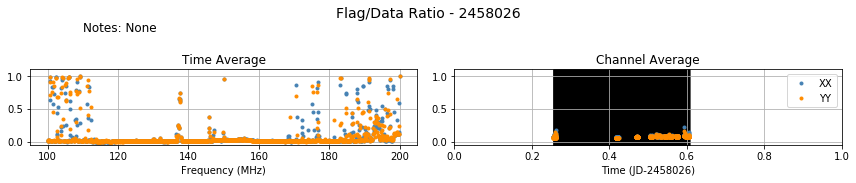

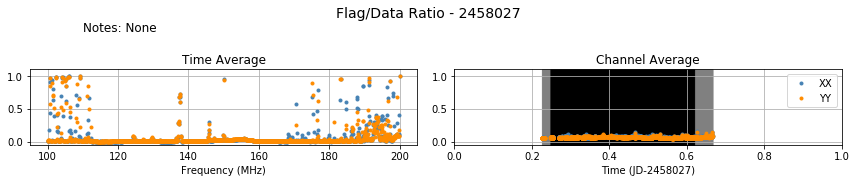

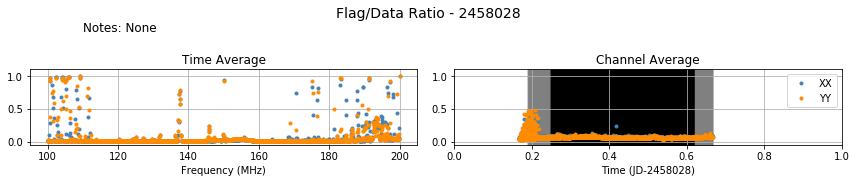

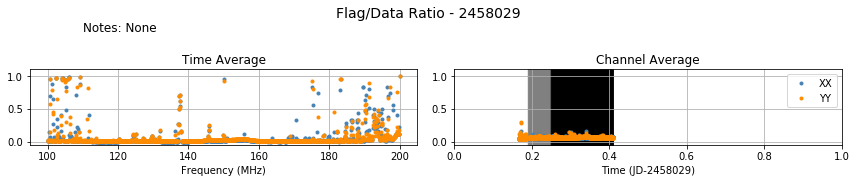

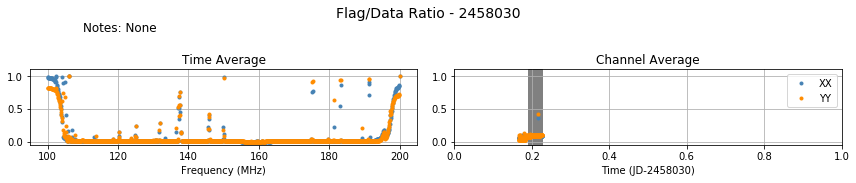

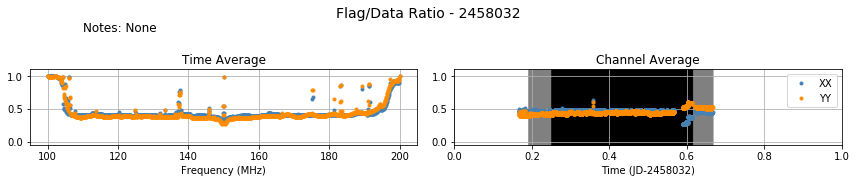

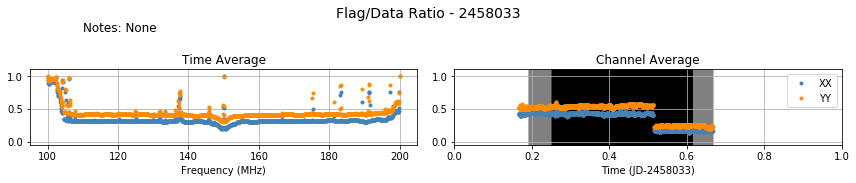

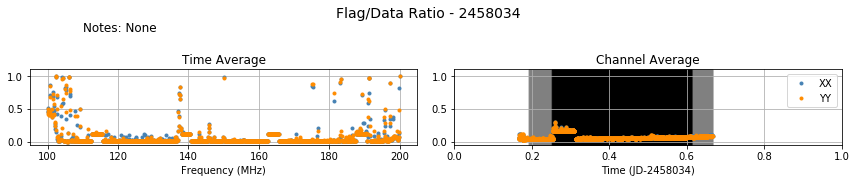

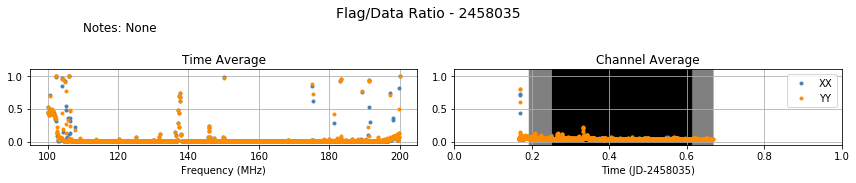

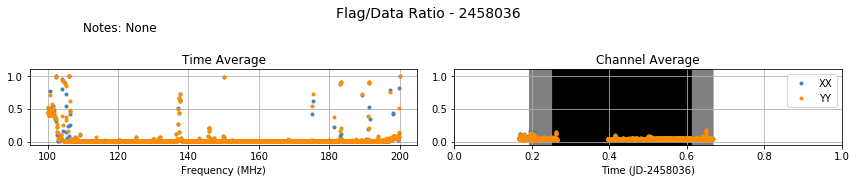

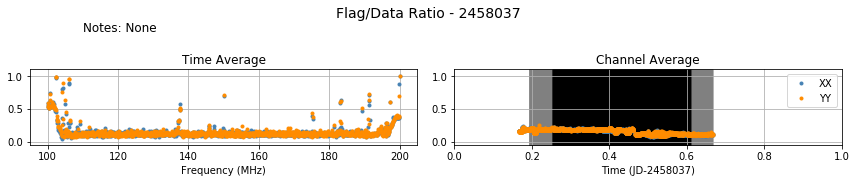

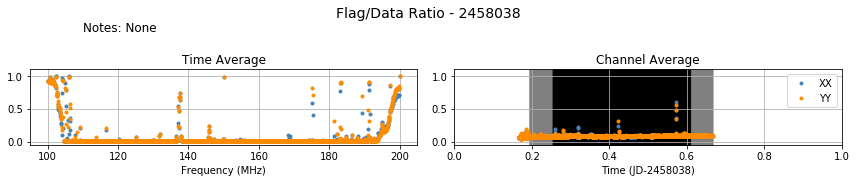

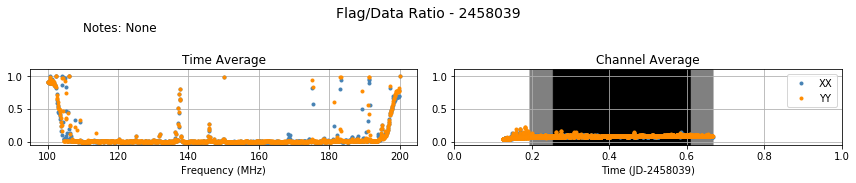

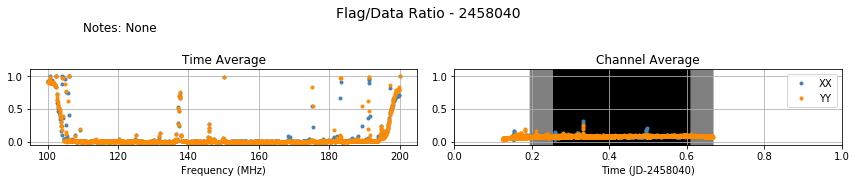

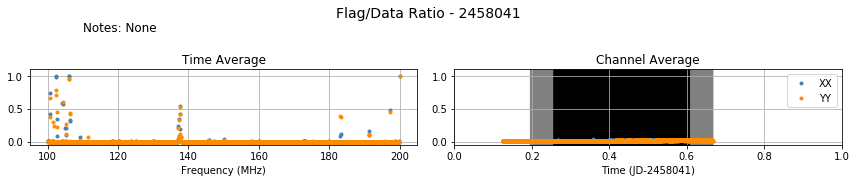

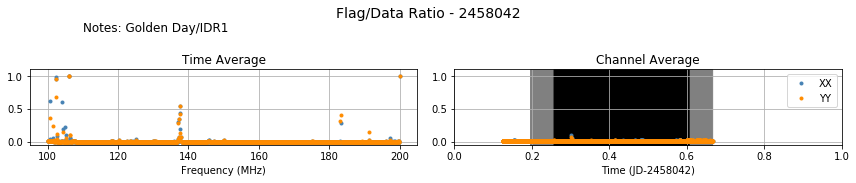

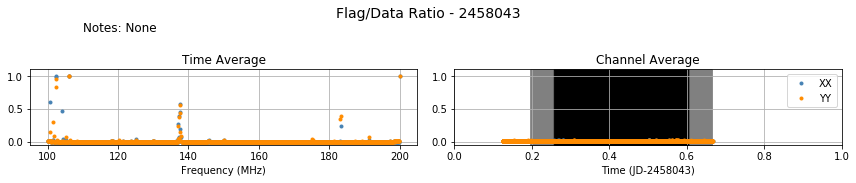

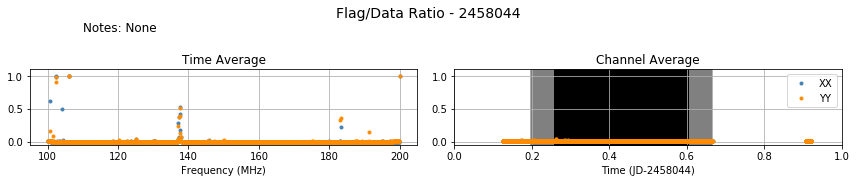

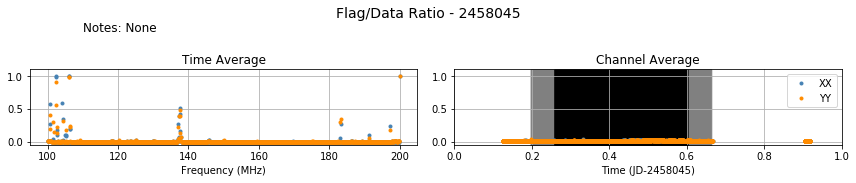

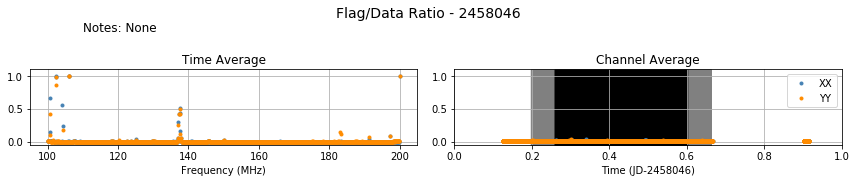

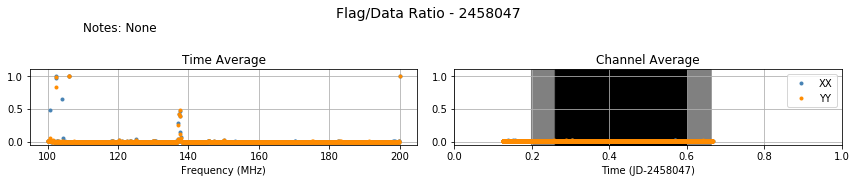

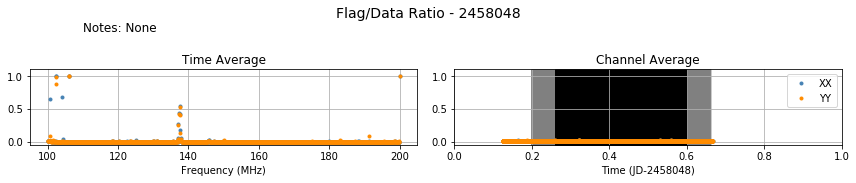

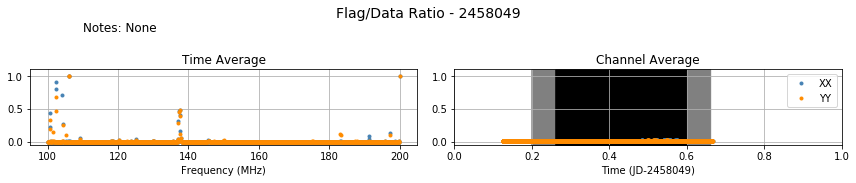

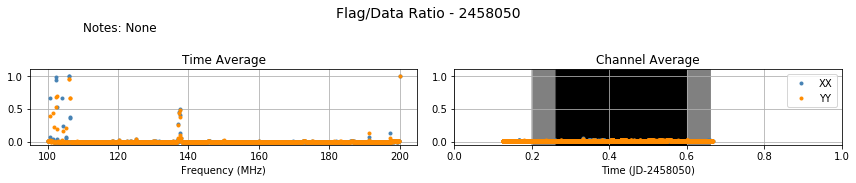

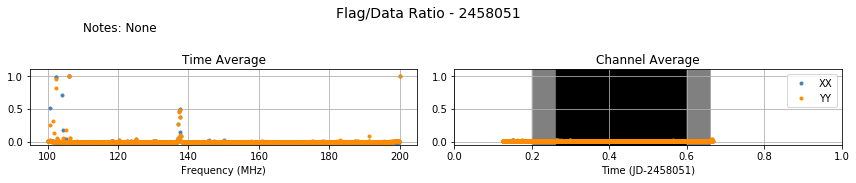

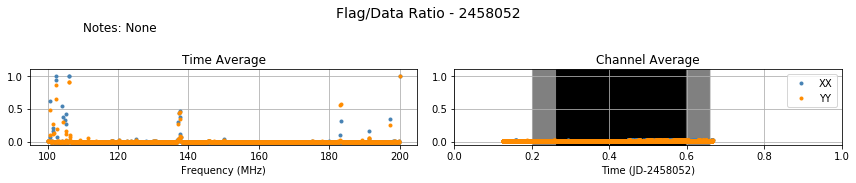

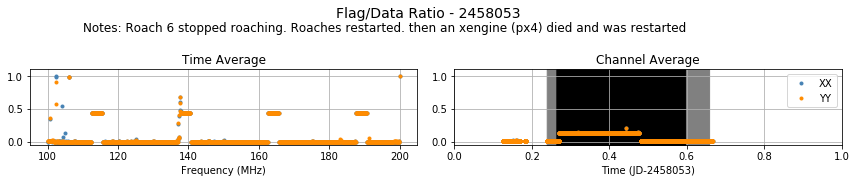

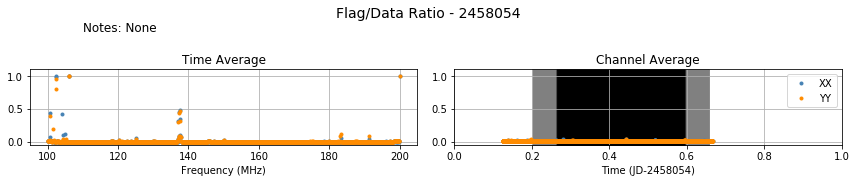

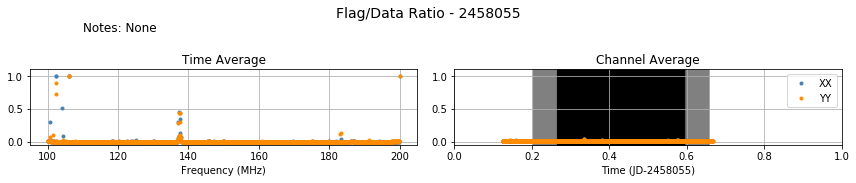

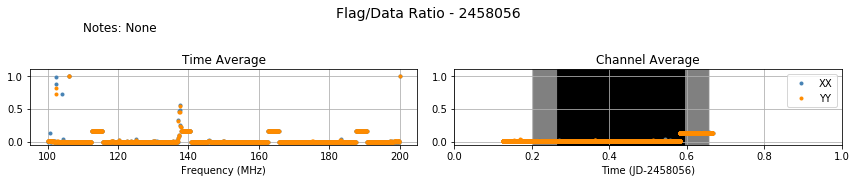

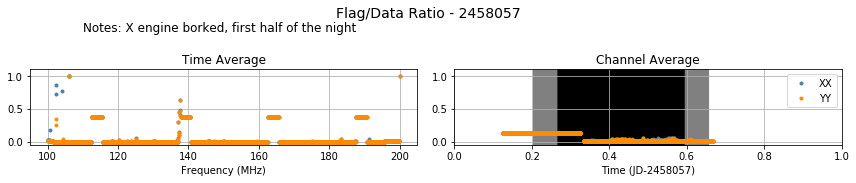

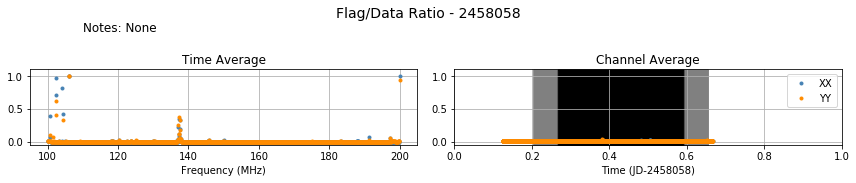

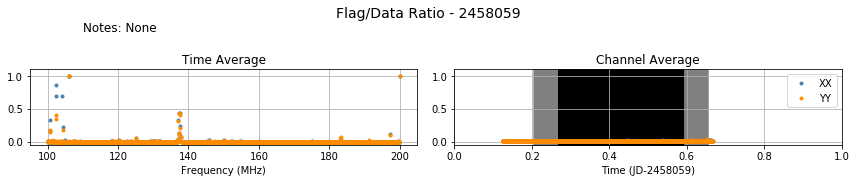

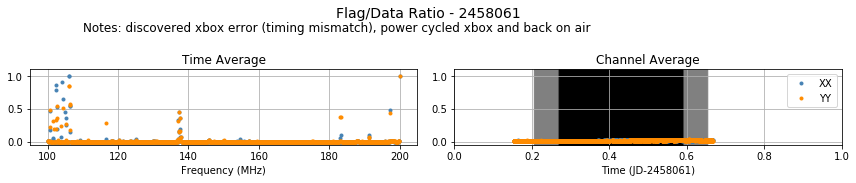

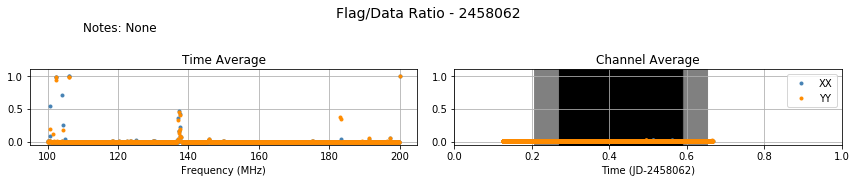

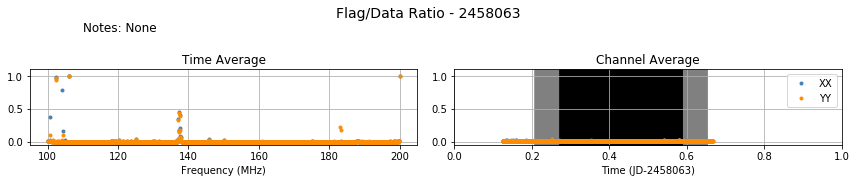

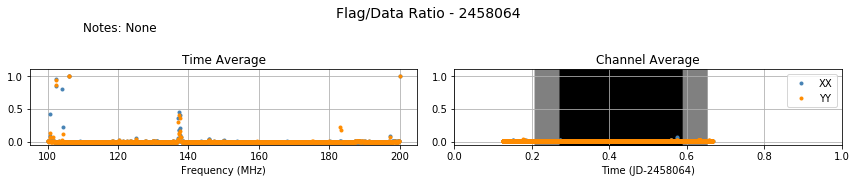

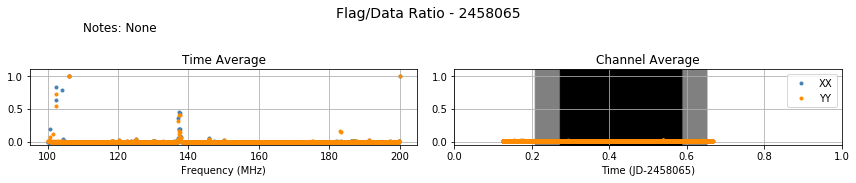

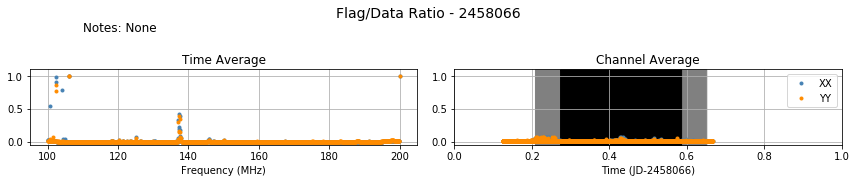

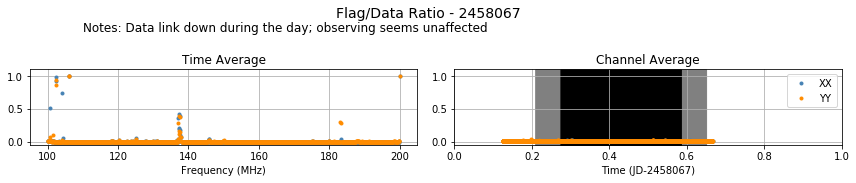

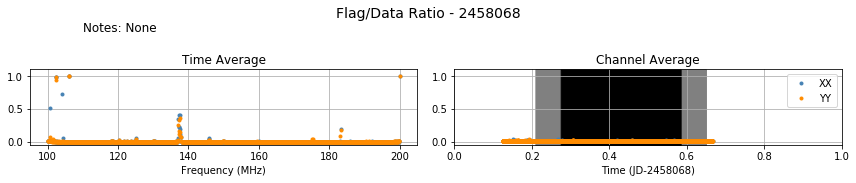

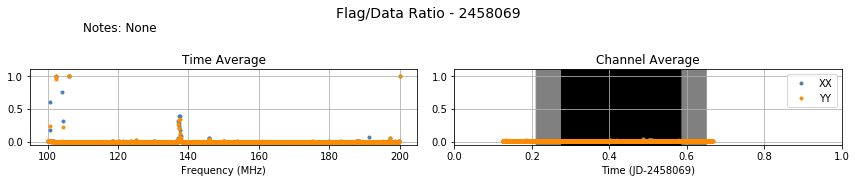

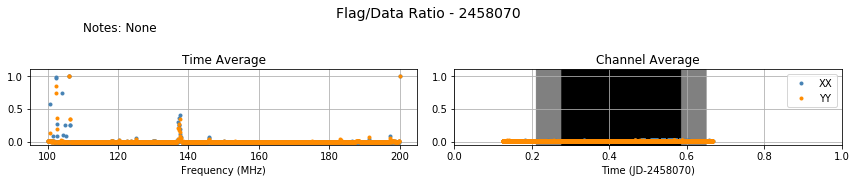

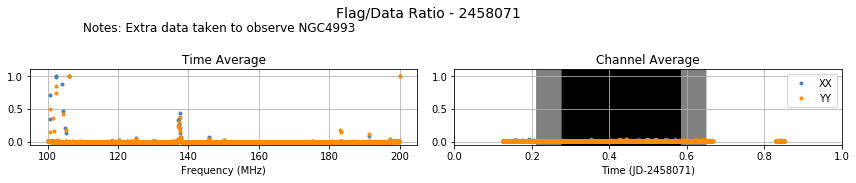

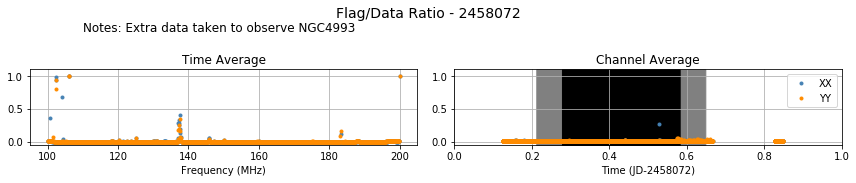

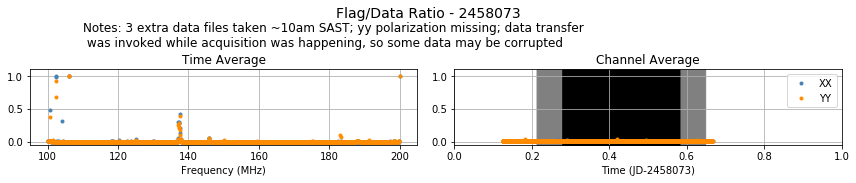

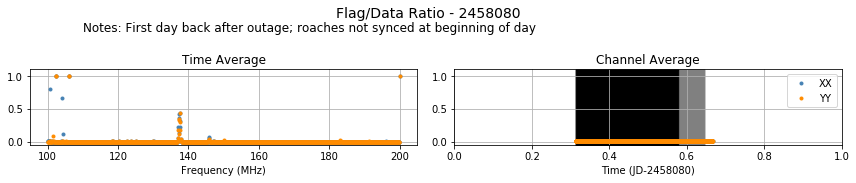

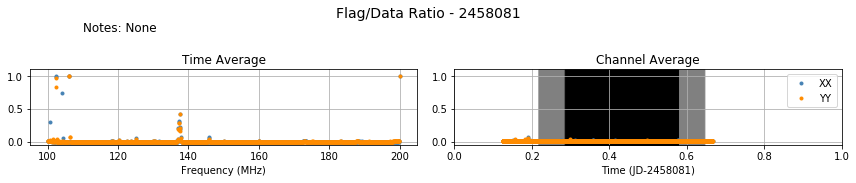

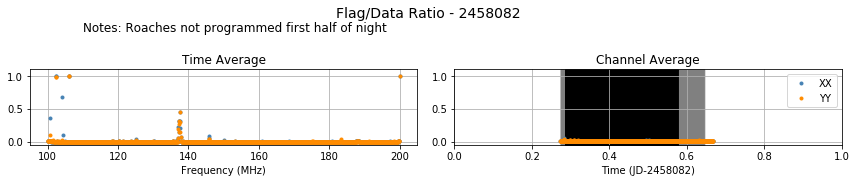

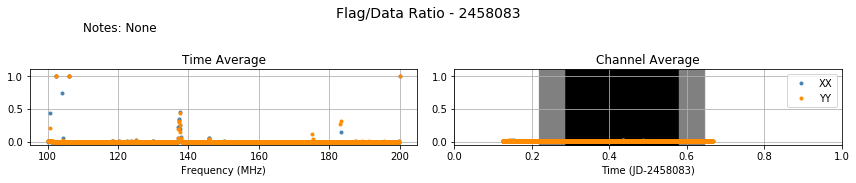

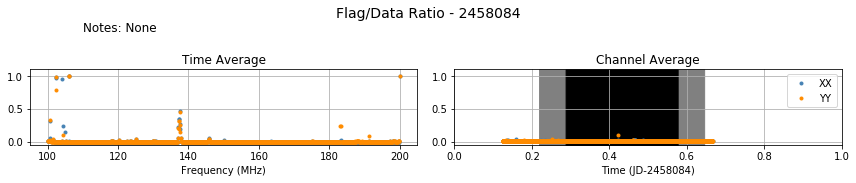

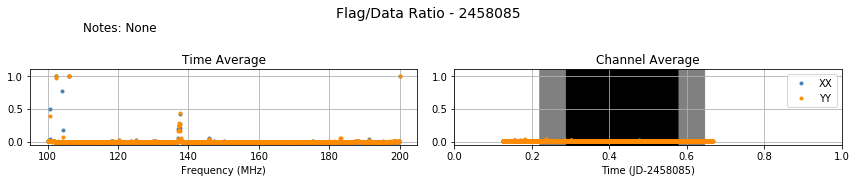

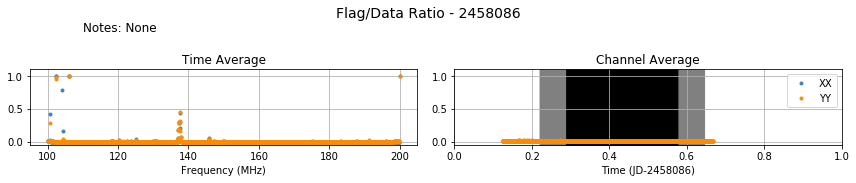

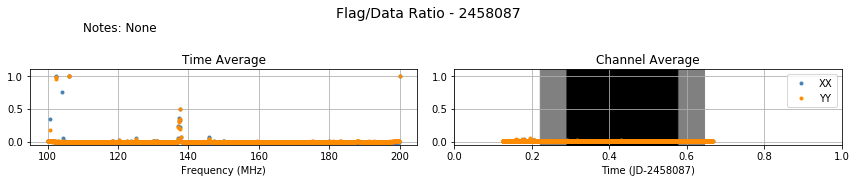

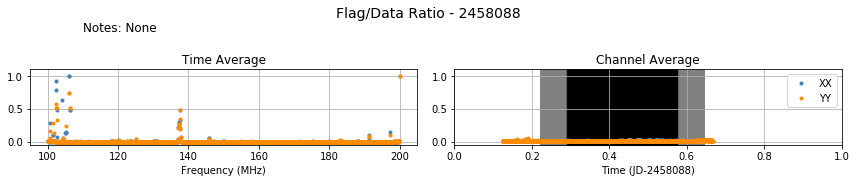

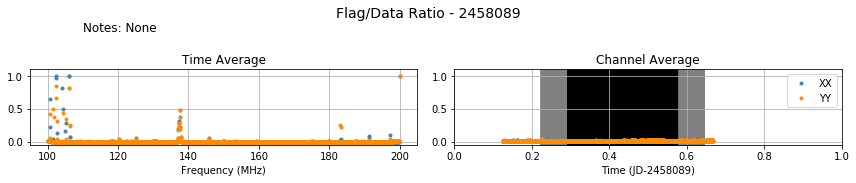

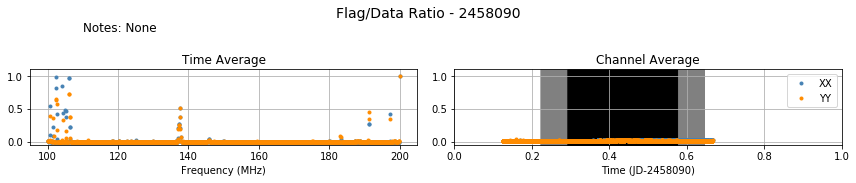

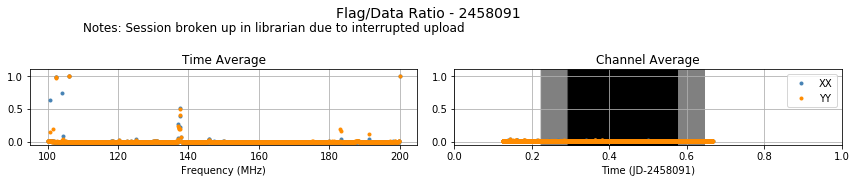

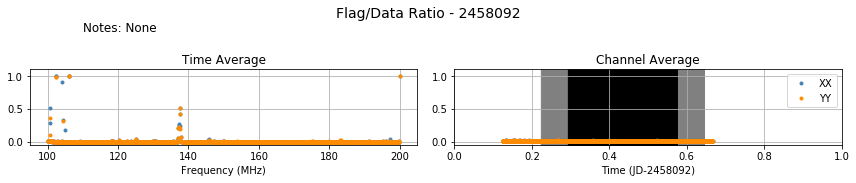

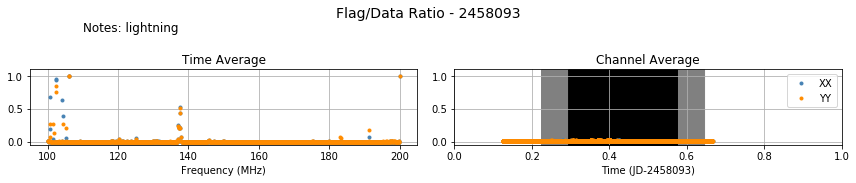

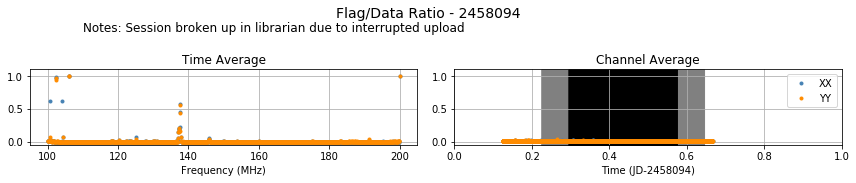

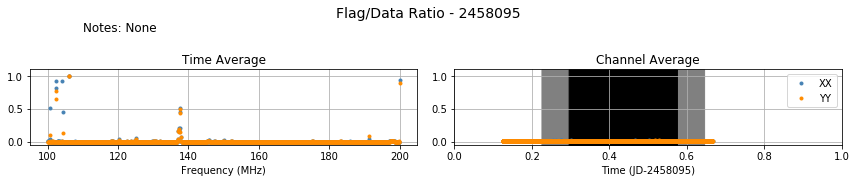

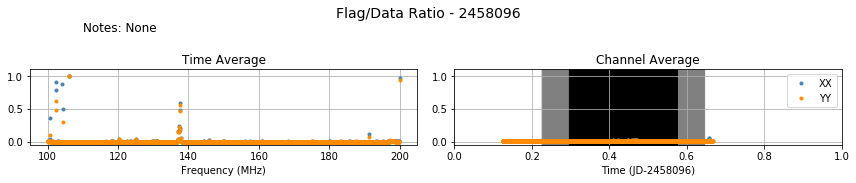

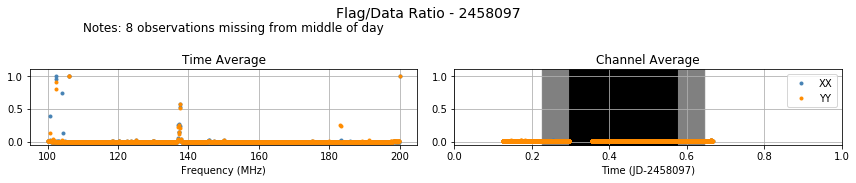

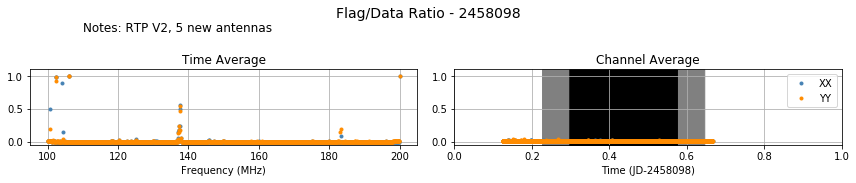

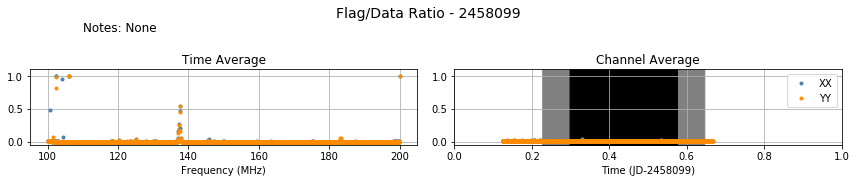

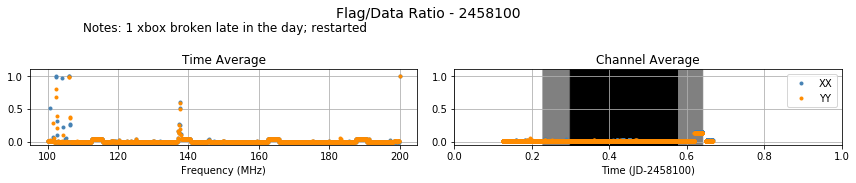

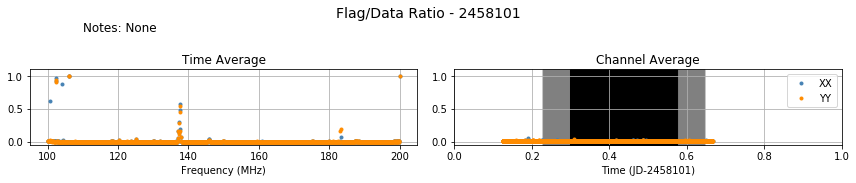

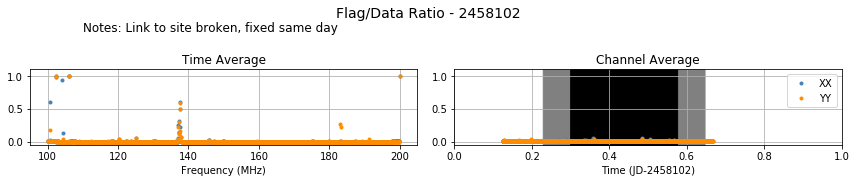

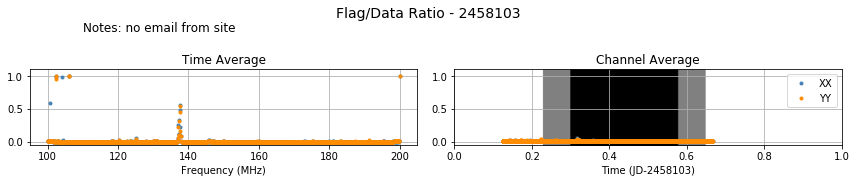

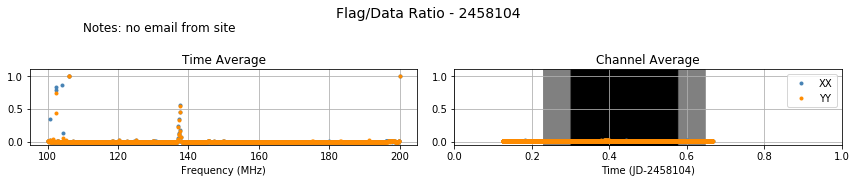

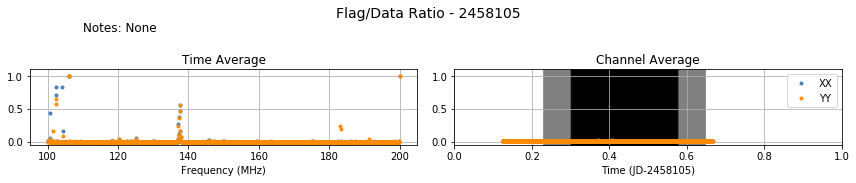

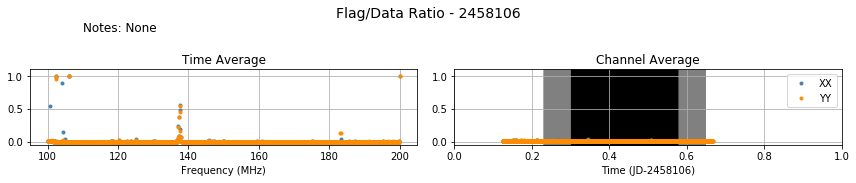

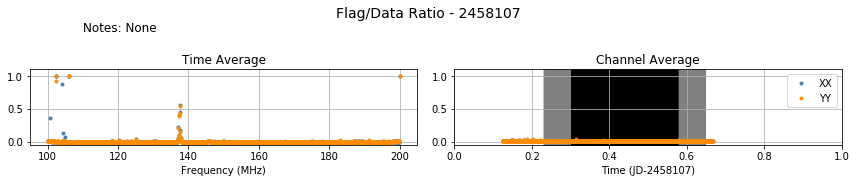

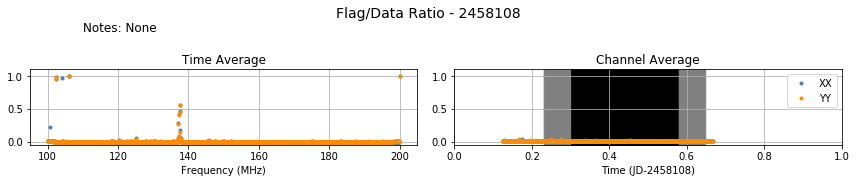

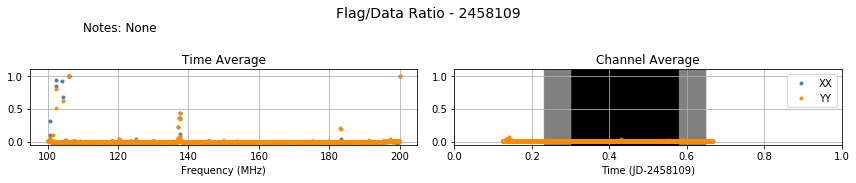

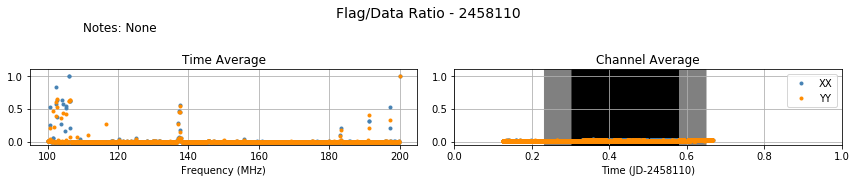

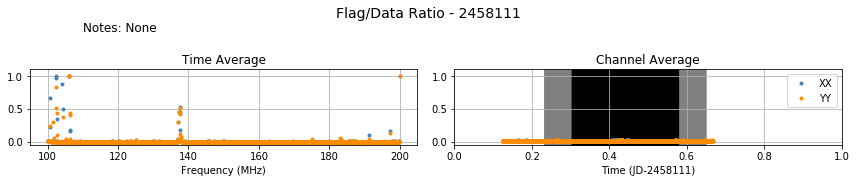

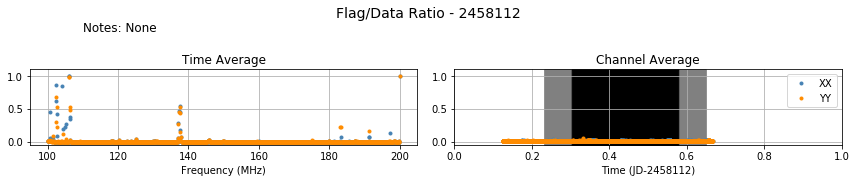

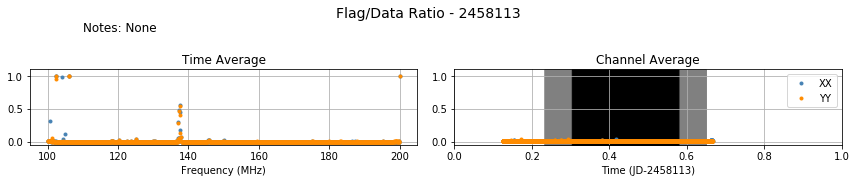

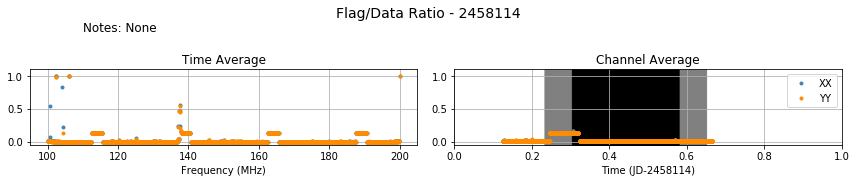

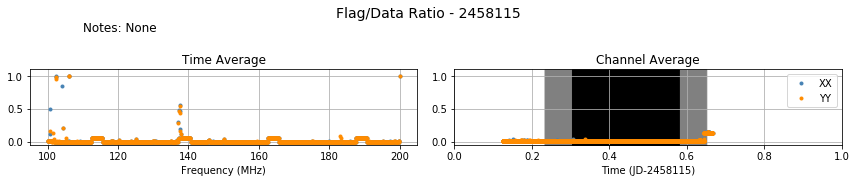

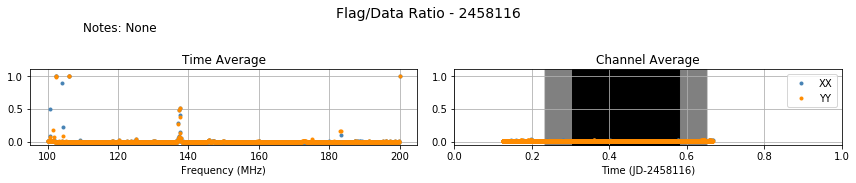

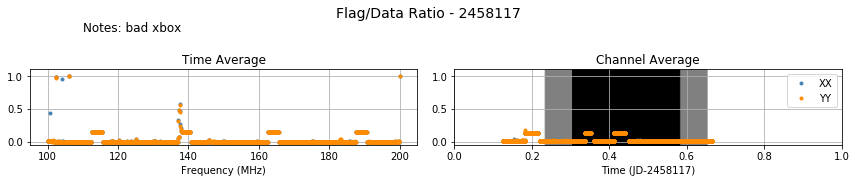

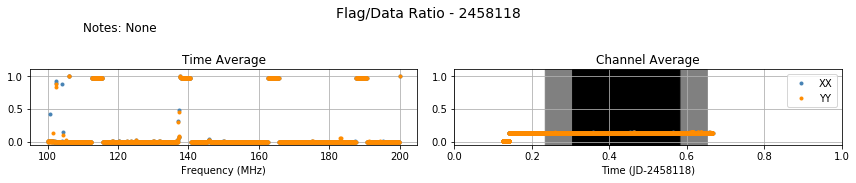

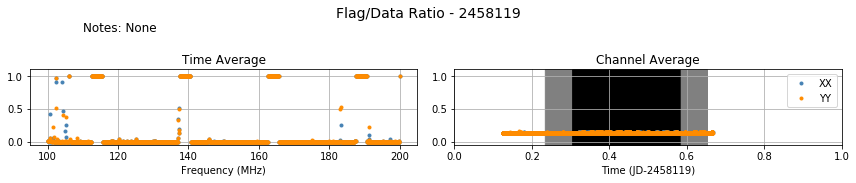

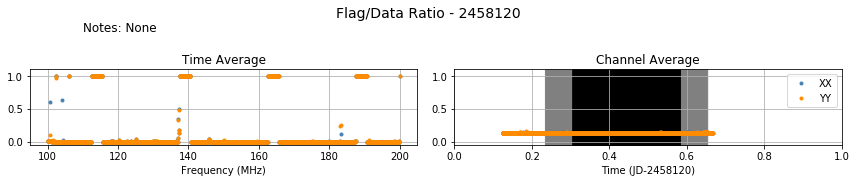

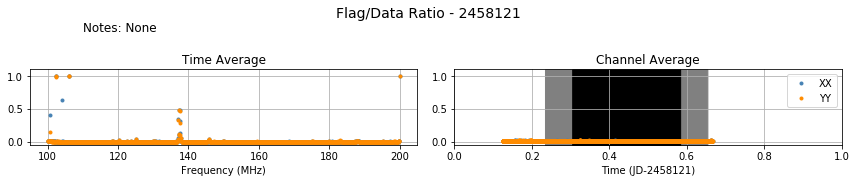

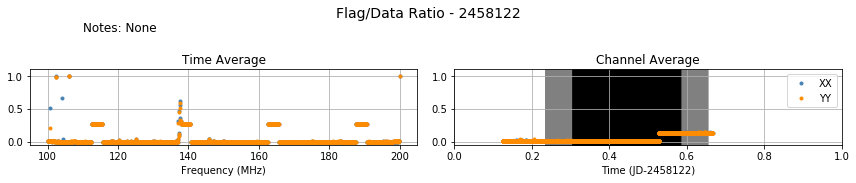

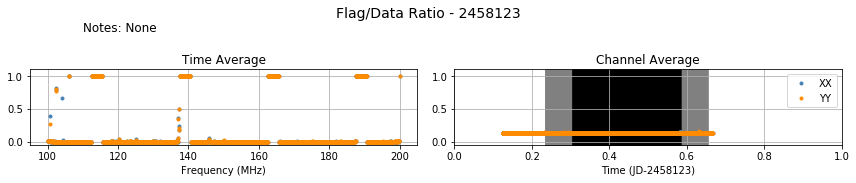

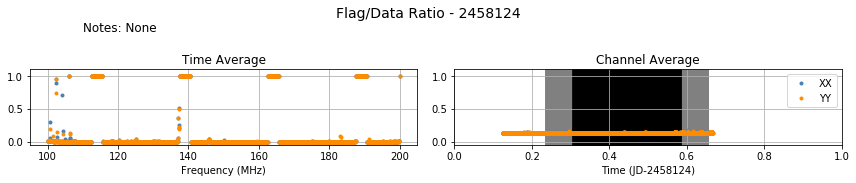

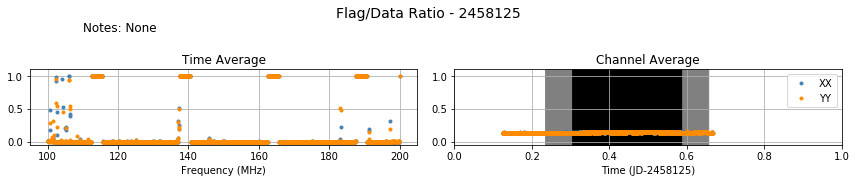

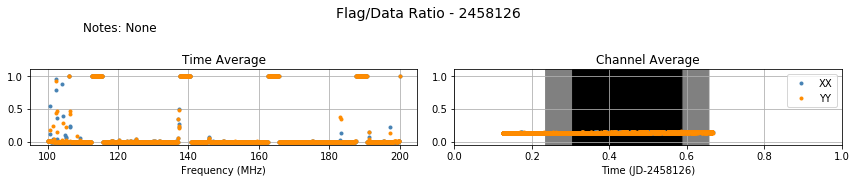

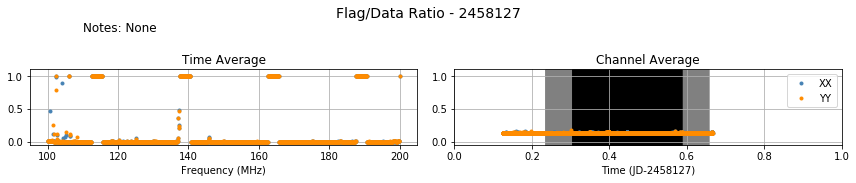

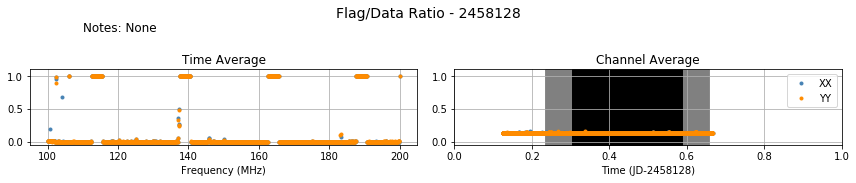

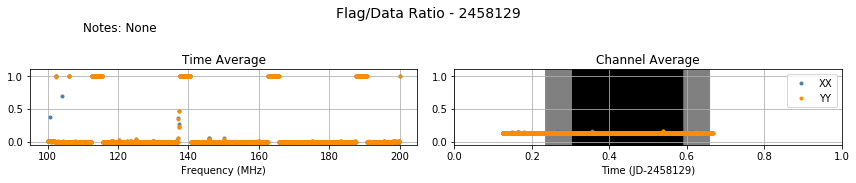

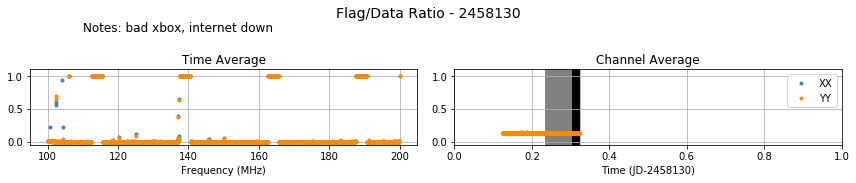

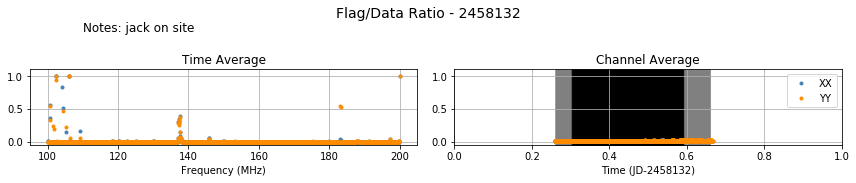

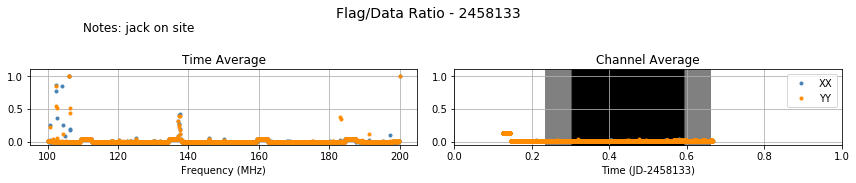

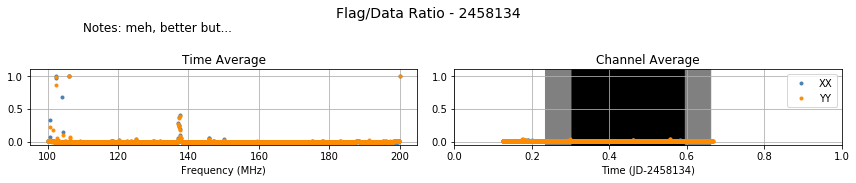

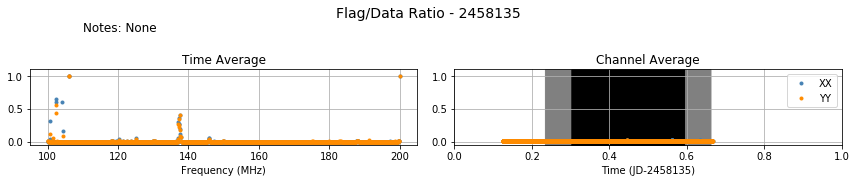

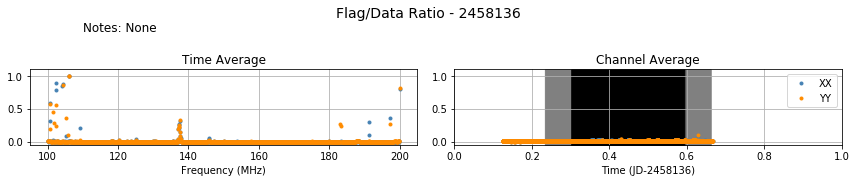

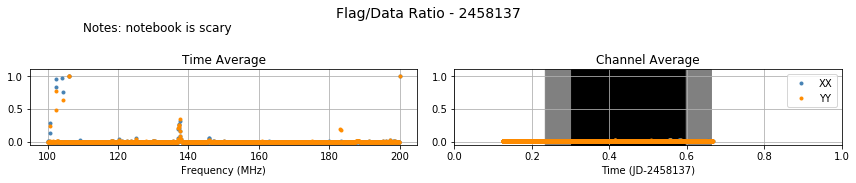

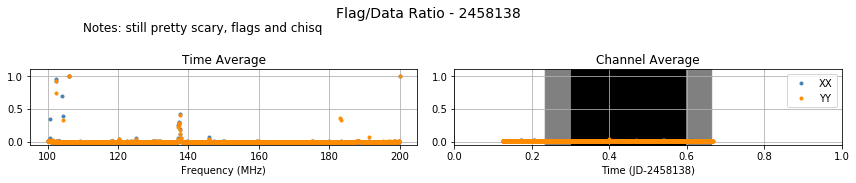

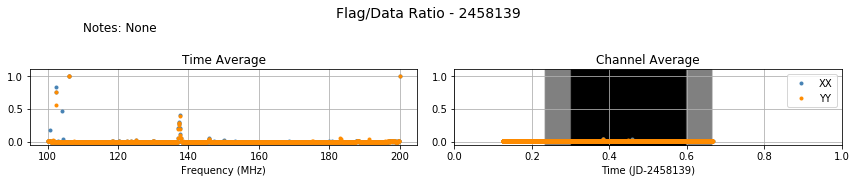

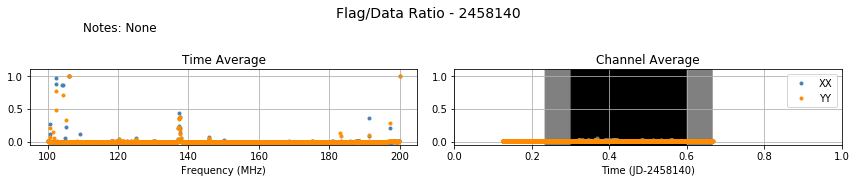

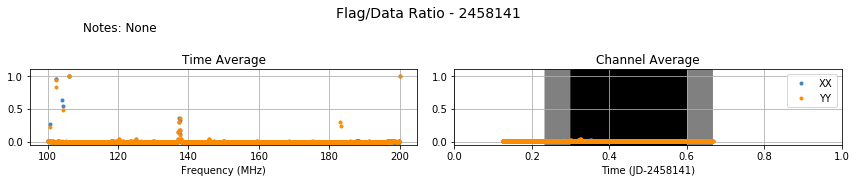

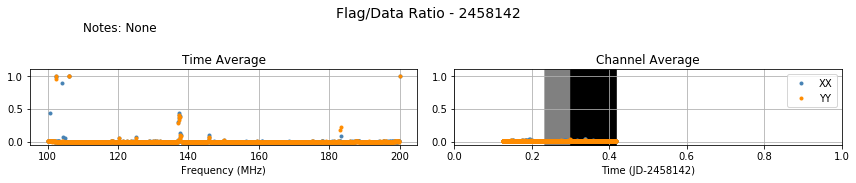

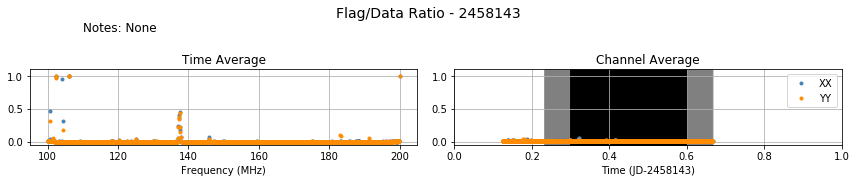

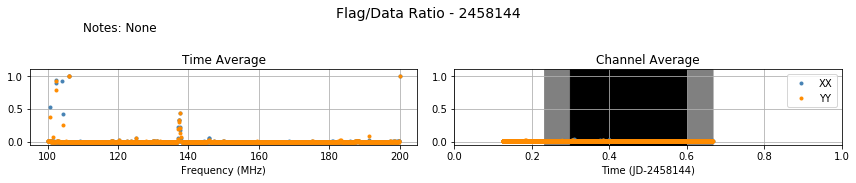

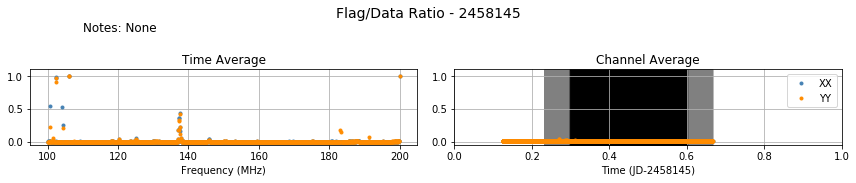

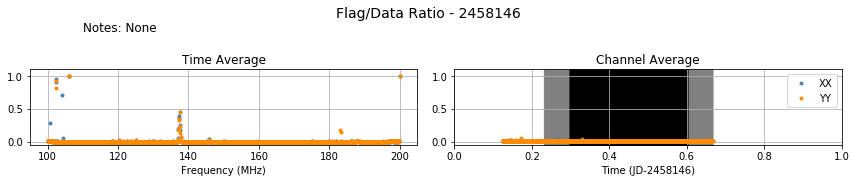

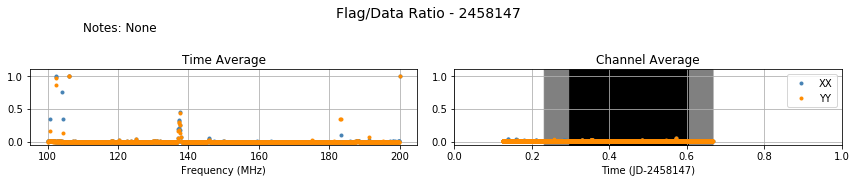

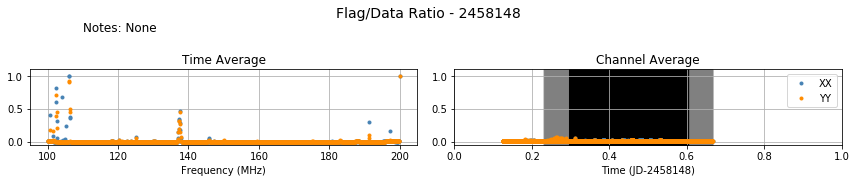

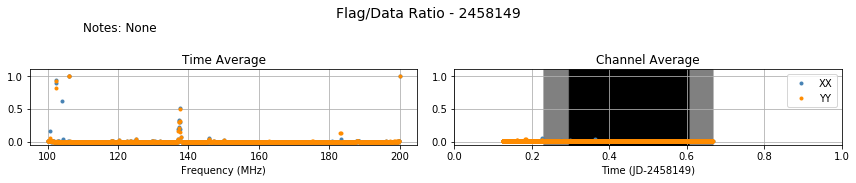

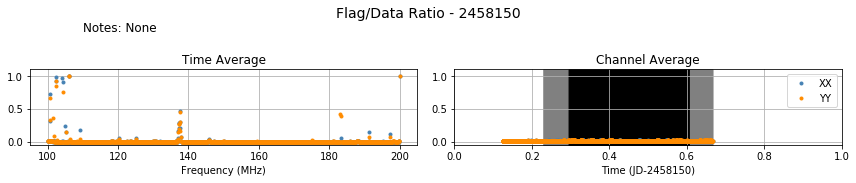

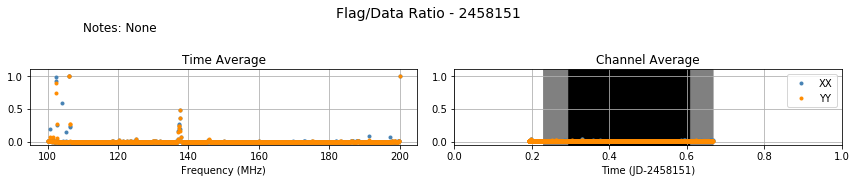

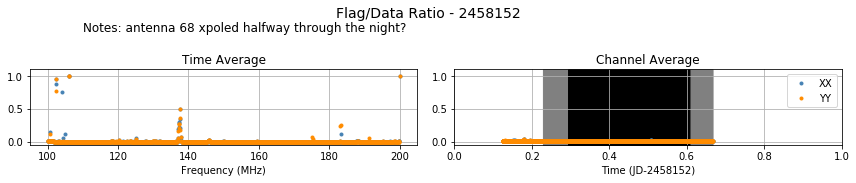

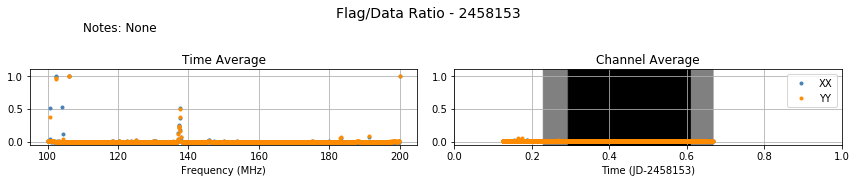

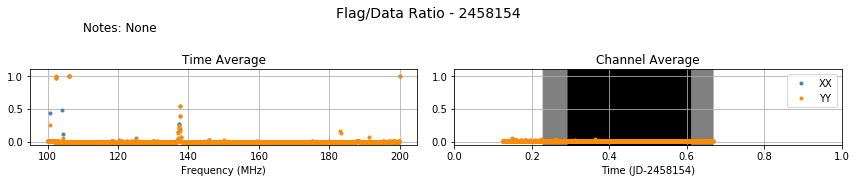

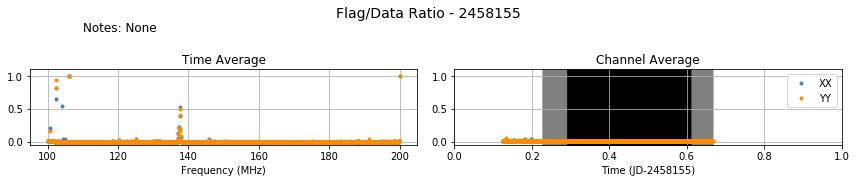

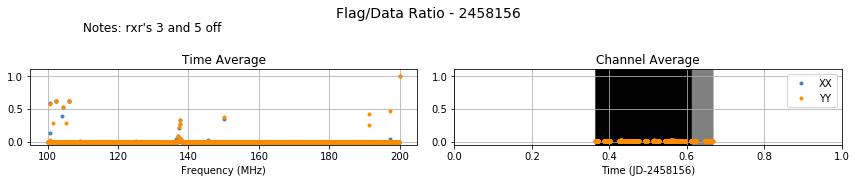

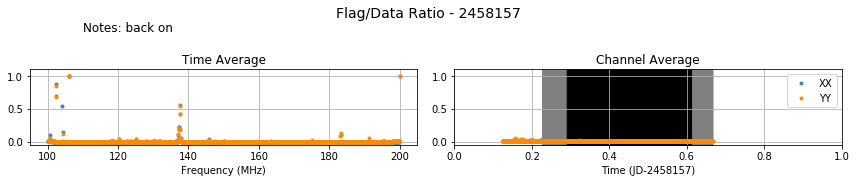

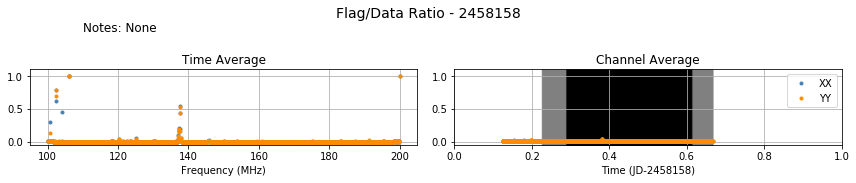

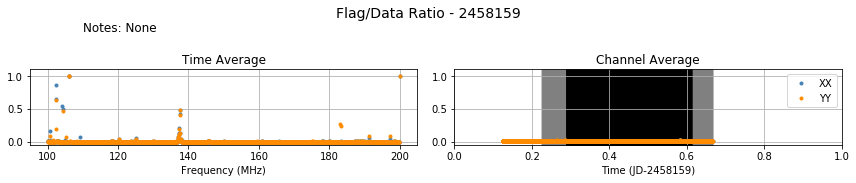

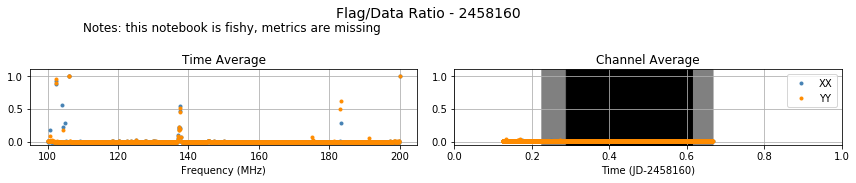

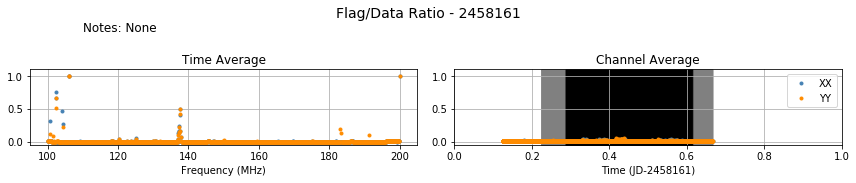

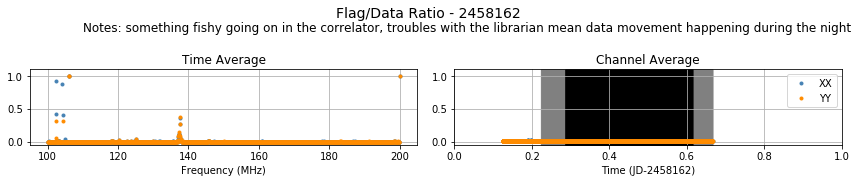

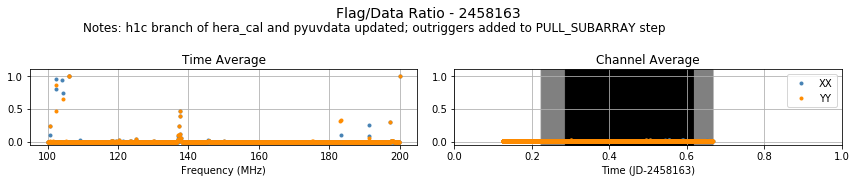

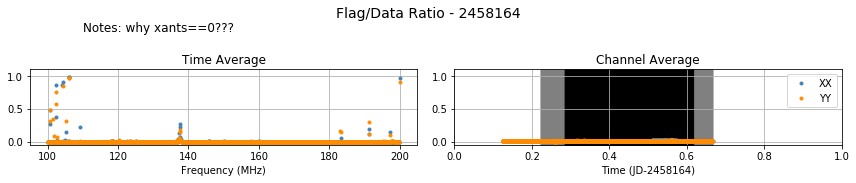

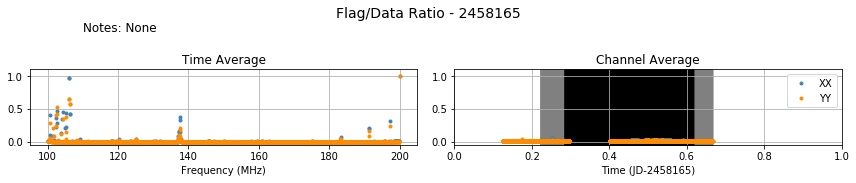

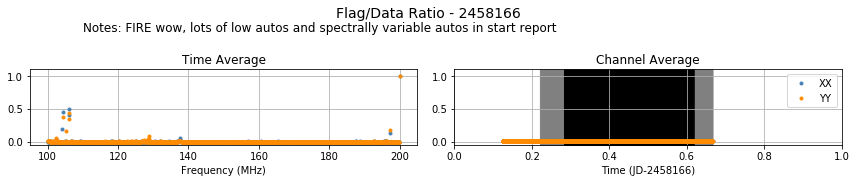

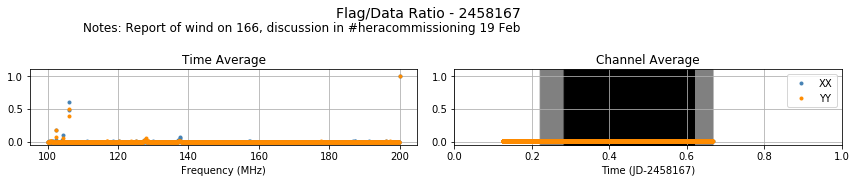

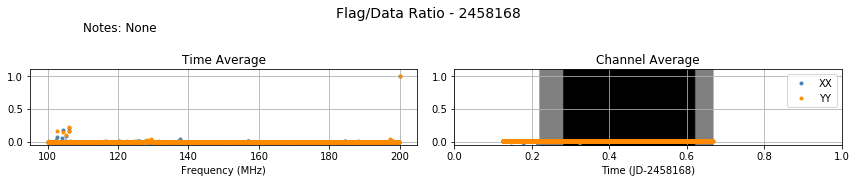

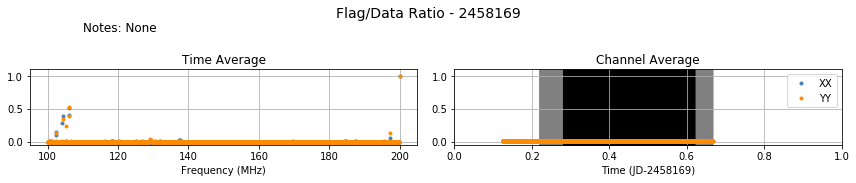

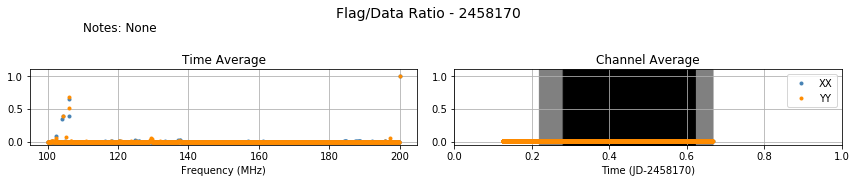

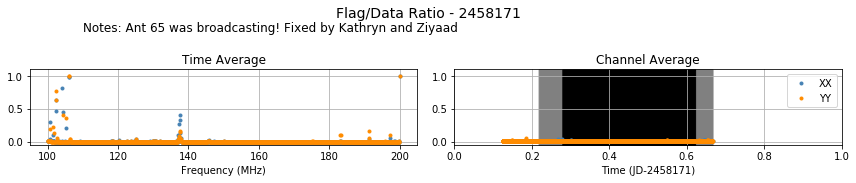

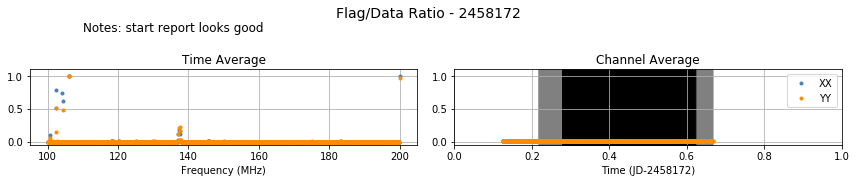

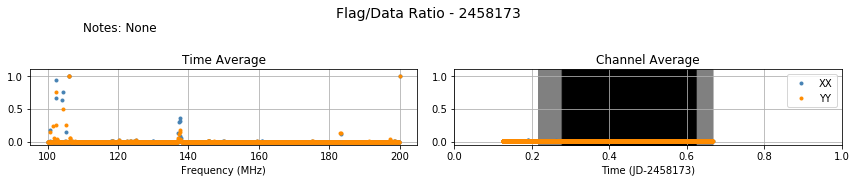

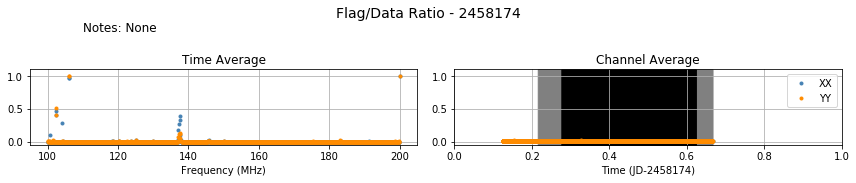

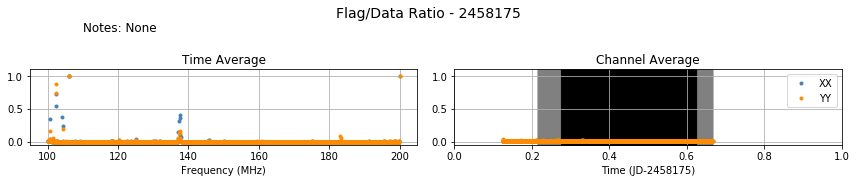

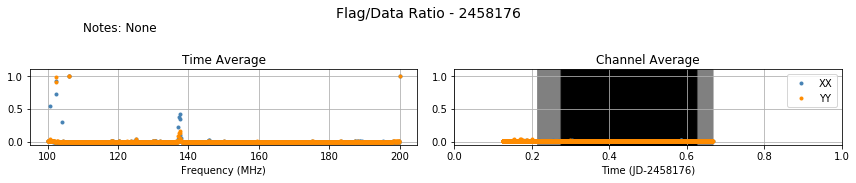

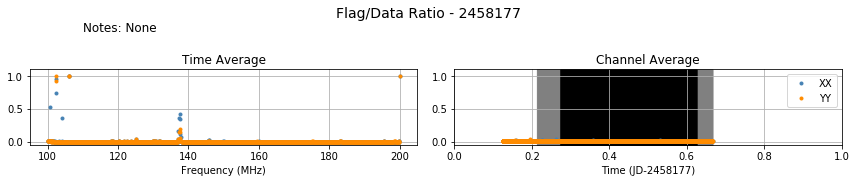

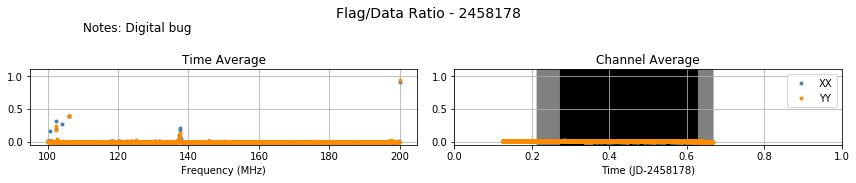

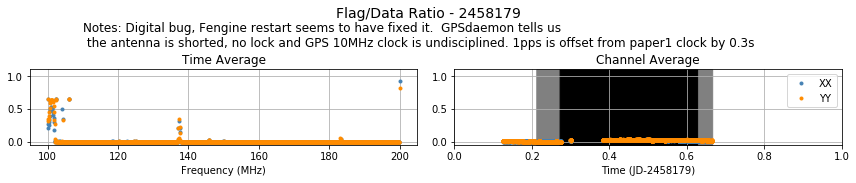

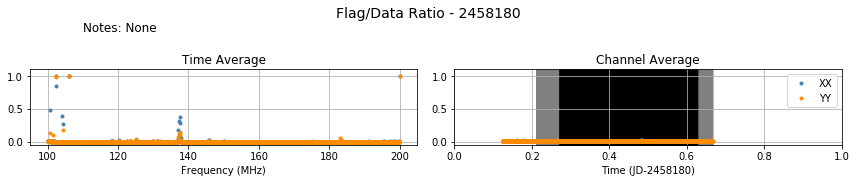

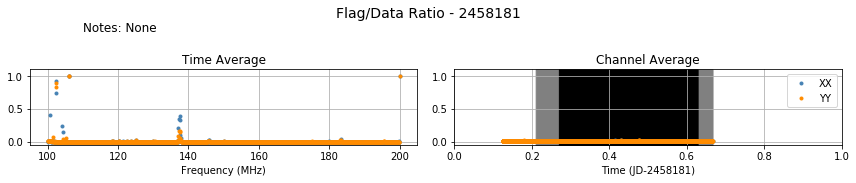

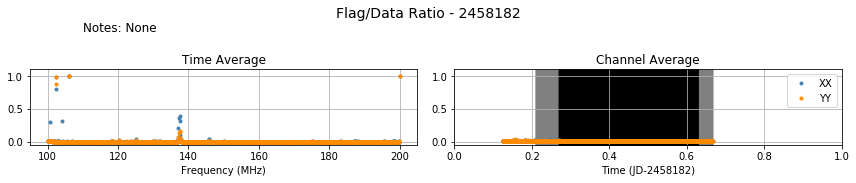

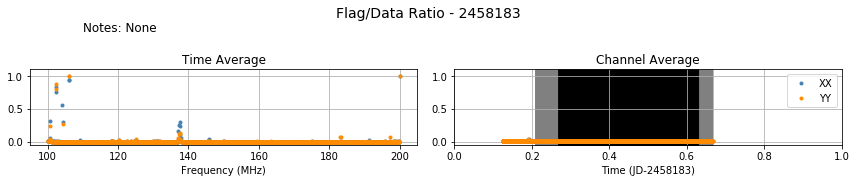

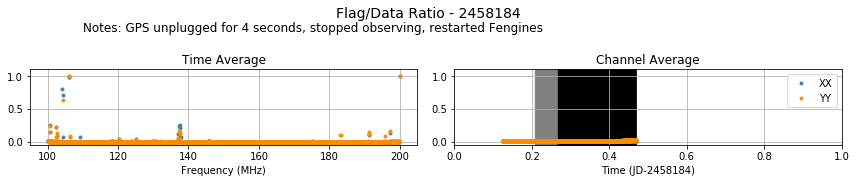

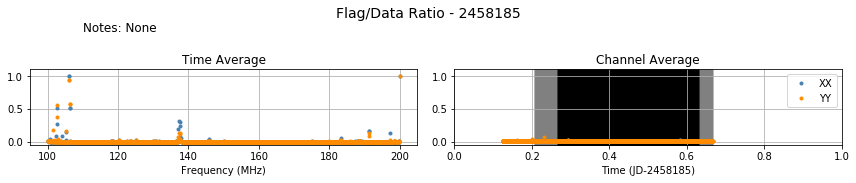

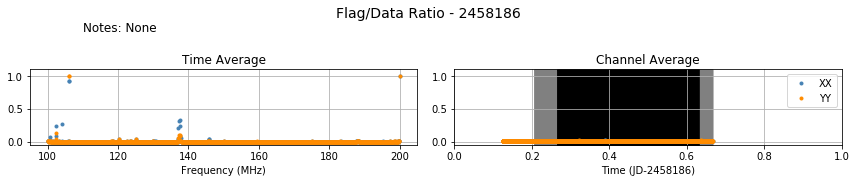

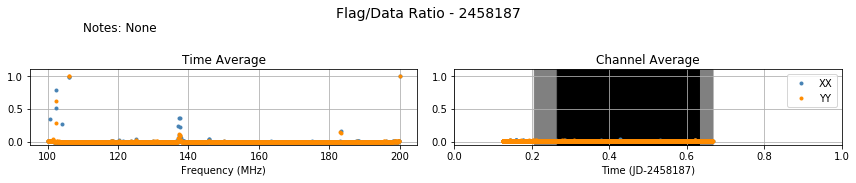

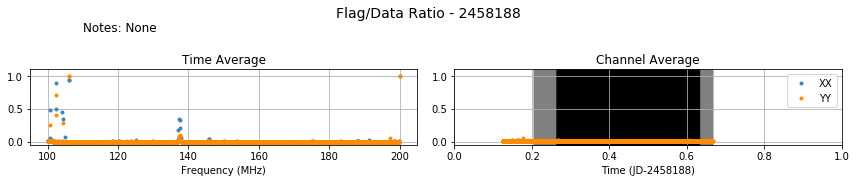

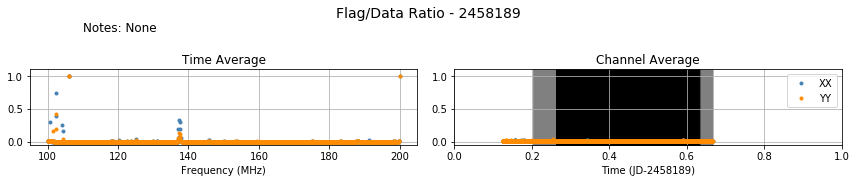

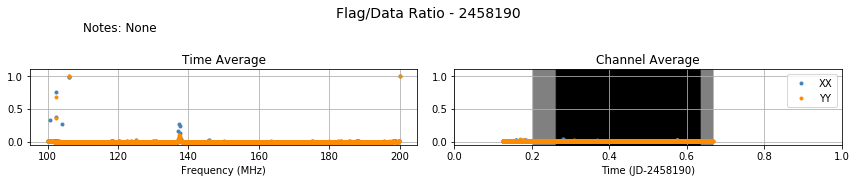

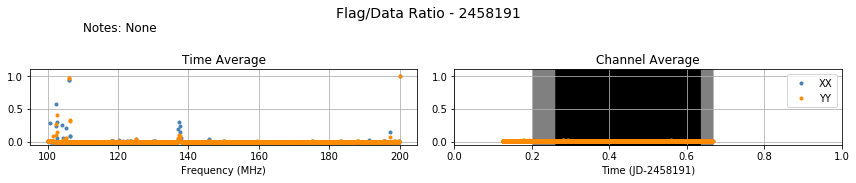

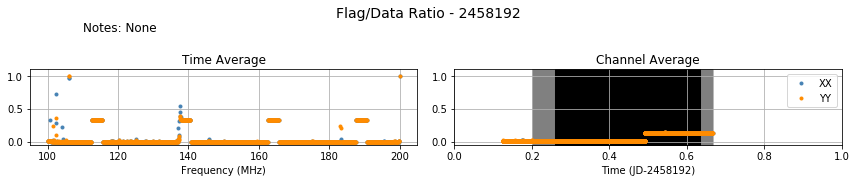

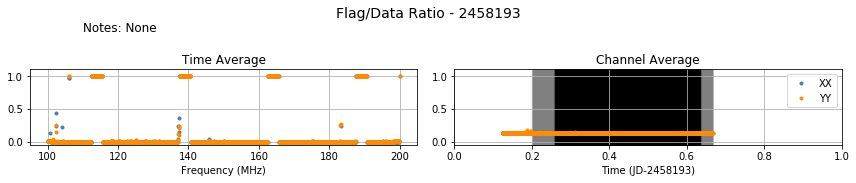

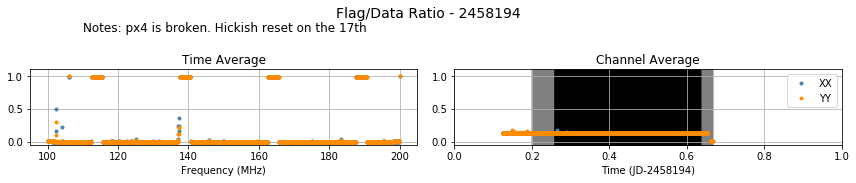

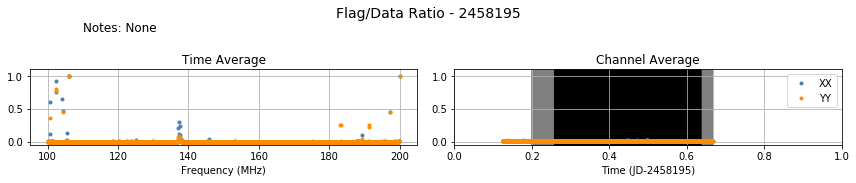

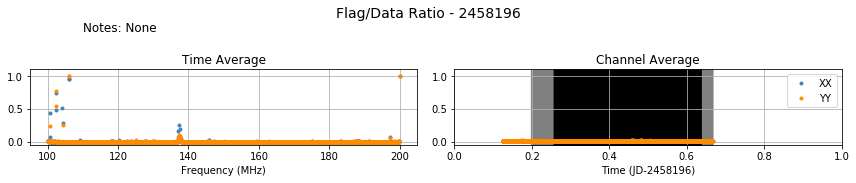

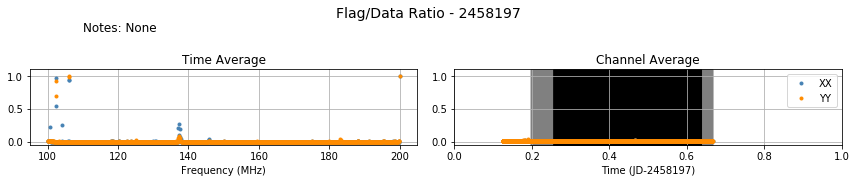

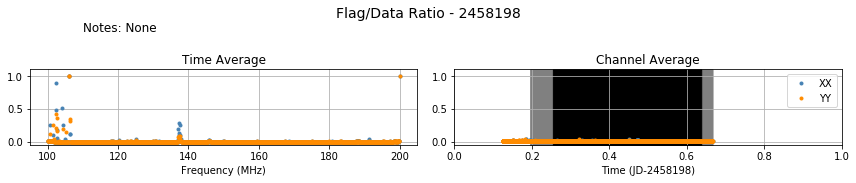

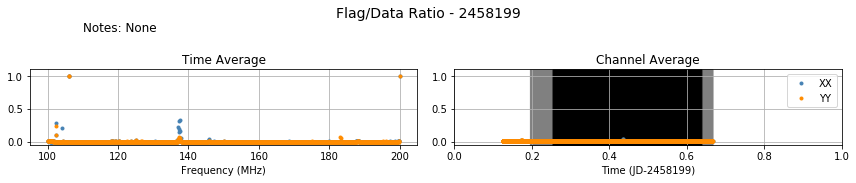

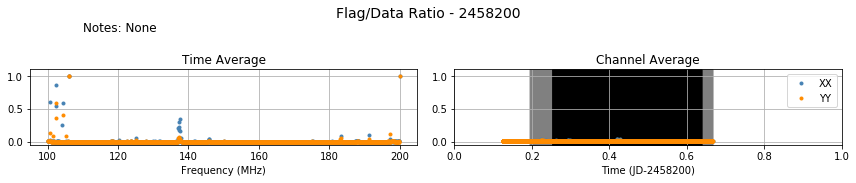

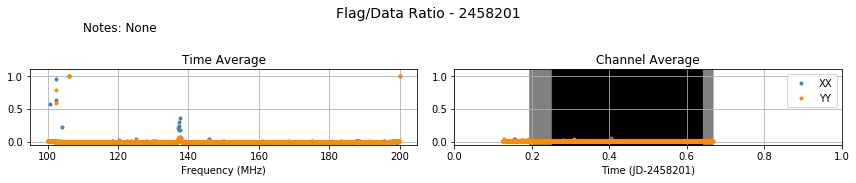

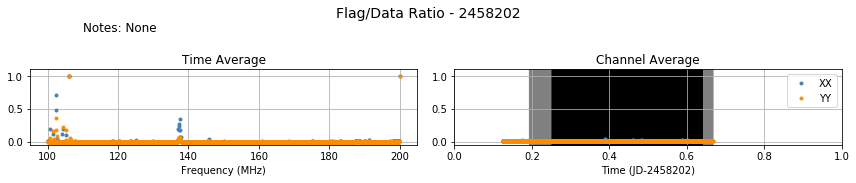

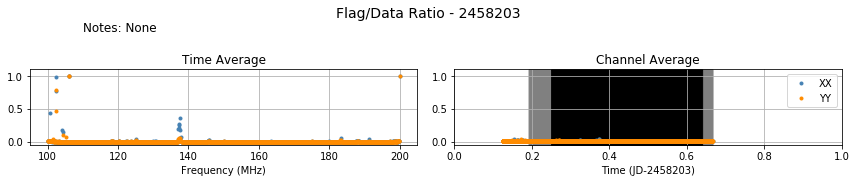

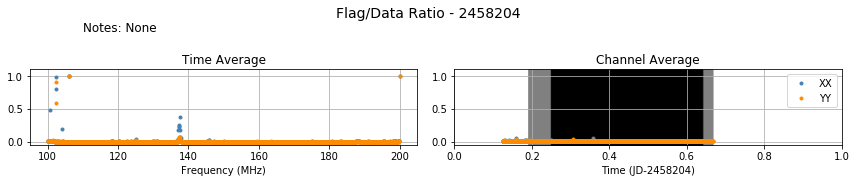

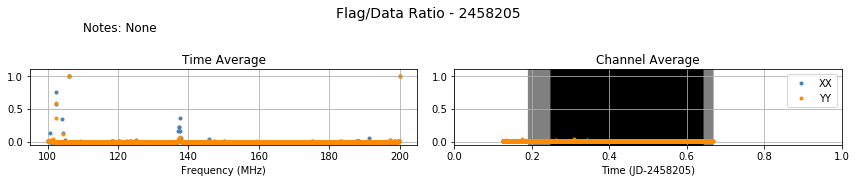

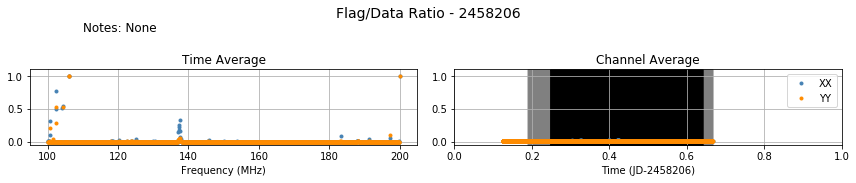

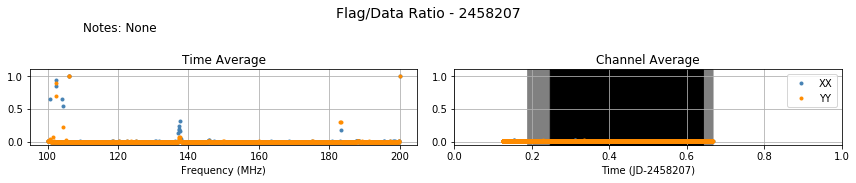

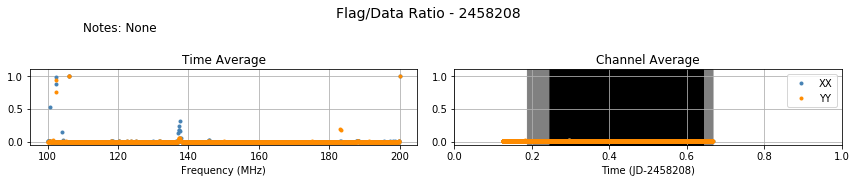

In [10]:

#plt.suptitle('Flag/Data Ratio - ' + os.path.split(DATA_PATH)[1]+' (flags_summary.npz) (baseline averaged)', y=1.05, fontsize=18)
    #Generate time averaged plots:
for i, flagfile in enumerate(plot_files):
    
    plot_arrays=np.load(flagfile)
    #freqtrail[i]=plot_arrays['chan_mean_xx']    
    fig=plt.figure(figsize=(12,2))
    plt.suptitle('Flag/Data Ratio - ' + os.path.split(flagfile)[1][:7], y=1.25, fontsize=14)
    plt.figtext(.1,1.15,'Notes: ' + notes[i][1], fontsize=12,verticalalignment='top')

    ax=fig.add_subplot(1,2,1)

    ax.grid()
    
    ax.set_ylim(-.05,1.1)
    if int(os.path.split(flagfile)[1][:7])>2458040:
        chantrail[i]=plot_arrays['time_mean_xx']
        ax.plot(freqs,plot_arrays['time_mean_xx'], color='steelblue', marker='.', ls='', label='XX')
        ax.plot(freqs,plot_arrays['time_mean_yy'], color='darkorange', marker='.', ls='', label='YY')
    else:
        chantrail[i]=plot_arrays['time_mean_xx_old']
        ax.plot(freqs,plot_arrays['time_mean_xx_old'], color='steelblue', marker='.', ls='', label='XX')
        ax.plot(freqs,plot_arrays['time_mean_yy_old'], color='darkorange', marker='.', ls='', label='YY')
        
    ax.set_xlabel('Frequency (MHz)')
    plt.title('Time Average')
    plt.tight_layout()
    
    
    #Frequency averaged plot
    arrlen=len(plot_arrays['chan_mean_xx'])
    xlim=4380 if (arrlen<4380) else arrlen
    ax2=fig.add_subplot(1,2,2)
    ax2.grid()
    ax2.set_xlim(0, 1)
    #ax2.set_xlim(0, xlim)
    ax2.set_ylim(-0.05,1.1)
    if int(os.path.split(flagfile)[1][:7])>2458040:
        ax2.plot(plot_arrays['flag_times_xx']-int(notes[i][0]),plot_arrays['chan_mean_xx'], color='steelblue', marker='.', ls='',label='XX')
        ax2.plot(plot_arrays['flag_times_yy']-int(notes[i][0]),plot_arrays['chan_mean_yy'], color='darkorange', marker='.', ls='',label='YY')
    else:
        ax2.plot(plot_arrays['flag_times_xx']-int(notes[i][0]),plot_arrays['chan_mean_xx_old'], color='steelblue', marker='.', ls='',label='XX')
        ax2.plot(plot_arrays['flag_times_yy']-int(notes[i][0]),plot_arrays['chan_mean_yy_old'], color='darkorange', marker='.', ls='',label='YY')
        
    ax2.fill_between(plot_arrays['flag_times_xx']-int(notes[i][0]), -1.1, 1.1, sunAltAz[i].alt < -0*u.deg, color='0.5', zorder=0)
    ax2.fill_between(plot_arrays['flag_times_xx']-int(notes[i][0]), -1.1, 1.1, sunAltAz[i].alt < -18*u.deg, color='black', zorder=1)
    ax2.set_xlabel('Time (JD-'+notes[i][0]+')' )
    
    ax2.legend()
    plt.title('Channel Average')
    

    
    plt.tight_layout()
    plt.show()



Below is an input cell that will allow you to more closely inspect the plots associated with a given JD.

Please enter the desired JD of your observation as a 7 digit integer(eg. 2458042):  2458202


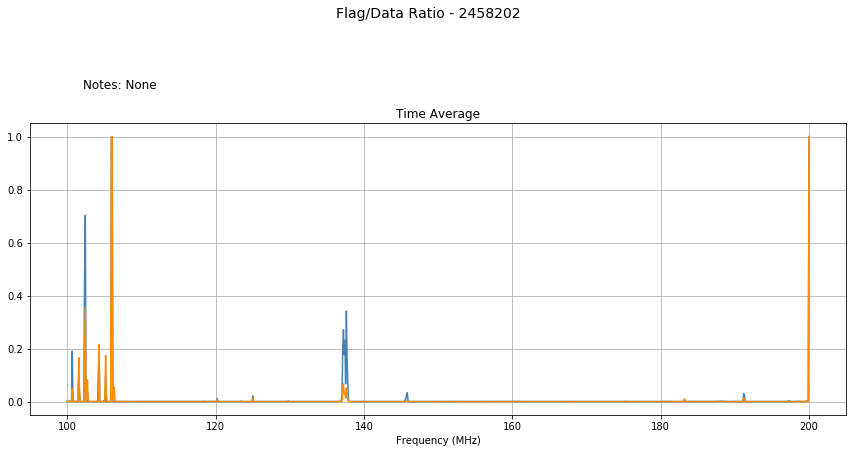

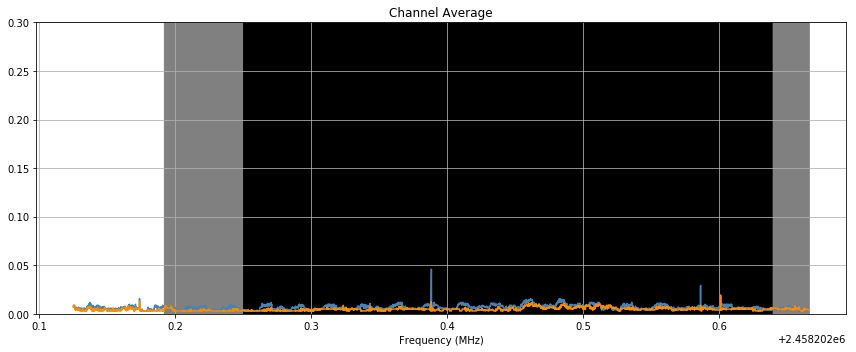

In [14]:
#code to inspect a particular file from user input
while True:
    jd_to_inspect=raw_input('Please enter the desired JD of your observation as a 7 digit integer(eg. 2458042): ')
    if any(jd_to_inspect in sublist for sublist in notes):
        break
    else:
        print ('Invalid JD, please enter the desired JD as a 7 digit integer(eg. 2458042): ')
    
    
file_to_inspect=np.load(DATA_PATH + '/'+jd_to_inspect+'_plot_arrays.npz')

fig=plt.figure(figsize=(12,5), facecolor='w')
# plt.style.use('dark_background')
fig.subplots_adjust(hspace=2)
plt.suptitle('Flag/Data Ratio - ' + jd_to_inspect, y=1.25, fontsize=14)
singlenote=[notes[i][1] for i,note in enumerate(notes) if notes[i][0]==jd_to_inspect]
singlesun=[sunAltAz[i] for i, note in enumerate(notes) if notes[i][0]==jd_to_inspect]
plt.figtext(.1,1.05,'Notes: ' + singlenote[0], fontsize=12,verticalalignment='top')

ax=fig.add_subplot(1,1,1)
#load this particular file

ax.grid()
# ax.set_ylim(-0.2,1.1)
ax.plot(freqs,file_to_inspect['time_mean_xx'], color='steelblue', ls='-')
ax.plot(freqs,file_to_inspect['time_mean_yy'], color='darkorange', ls='-')
ax.set_xlabel('Frequency (MHz)')

plt.title('Time Average')
plt.tight_layout()

#Frequency averaged plot
fig=plt.figure(figsize=(12,5),facecolor='w')
arrlen=len(plot_arrays['chan_mean_xx'])
xlim=4380 if (arrlen<4380) else arrlen
ax2=fig.add_subplot(1,1,1)
ax2.grid()
# ax2.set_xlim(0, 4380)
# ax2.set_xlim(0, xlim)
ax2.set_ylim(top=.3)
ax2.plot(file_to_inspect['flag_times_xx'],file_to_inspect['chan_mean_xx'], color='steelblue', ls='-')
ax2.plot(file_to_inspect['flag_times_yy'],file_to_inspect['chan_mean_yy'], color='darkorange', ls='-')
ax2.fill_between(file_to_inspect['flag_times_xx'], 0, 1.1, singlesun[0].alt < -0*u.deg, color='0.5', zorder=0)
ax2.fill_between(file_to_inspect['flag_times_xx'], 0, 1.1, singlesun[0].alt < -18*u.deg, color='black', zorder=1)
ax2.set_xlabel('Frequency (MHz)')

plt.title('Channel Average')
plt.tight_layout()
plt.show()

When we look at a JD with a blip, such as JD 2458202, we can see spikes in the flag fraction at various frequencies, as well as at certain LST.

In [16]:
for i in range(len(heraTimeYDT)):
    heraTimeLocal[i]=[0]*len(heraTimeYDT[i])
    for j in range(len(heraTimeYDT[i])):
        heraTimeLocal[i][j]=heraTimeYDT[i][j].time()

When we line up these flag fractions according to LST, we can see a small flag fraction spike that changes LST each evening. 

Text(0.5,0,'LST')

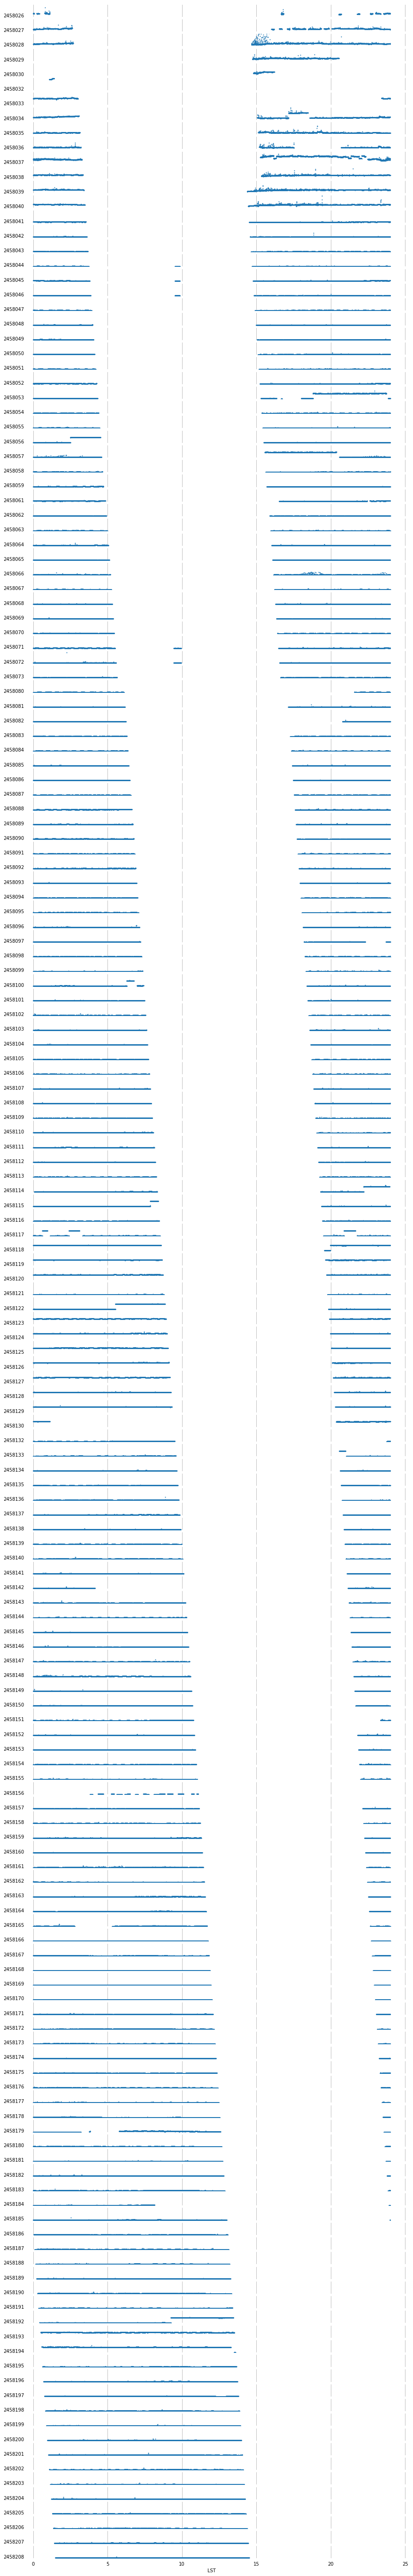

In [17]:
#plot using iterable vertical offset, horizontal offset based on LST
fig, axarr1=plt.subplots(numplts, 1, sharex='col', figsize=(15,100), facecolor='w')
for i, plotfile in enumerate(plot_files):
#     print i
    openFile=np.load(plotfile)
    if int(os.path.split(plotfile)[1][:7])>2458040:
        axarr1[i].plot(heraTimeLST[i], openFile['chan_mean_xx'], marker='.',markersize=2., ls='')
    else:
        axarr1[i].plot(heraTimeLST[i], openFile['chan_mean_xx_old'], marker='.',markersize=2., ls='')

    axarr1[i].yaxis.set_visible(False)
    axarr1[i].set_ylim(0,.3)
    axarr1[i].tick_params(axis='x', bottom=False)
    axarr1[i].set_frame_on(False)
    axarr1[i].text(-2,0, notes[i][0])
    axarr1[i].grid()
    
plt.xlabel('LST')

In [23]:
#Choosing the JDs that feature the blip
blip_files_1=plot_files[103:121]
blip_files_2=plot_files[151:174]

blip_time_YDT1=heraTimeYDT[103:121]
blip_time_LST1=heraTimeLST[103:121]
blip_time_YDT2=heraTimeYDT[151:174]
blip_time_LST2=heraTimeLST[151:174]
blip_notes1=notes[103:121]
blip_notes2=notes[151:174]

#print(blip_files_1)

The plots below give a more precise view of the dates and movement of the blip. Note the movement in LST, as the spike recurrs slightly earilier each day.

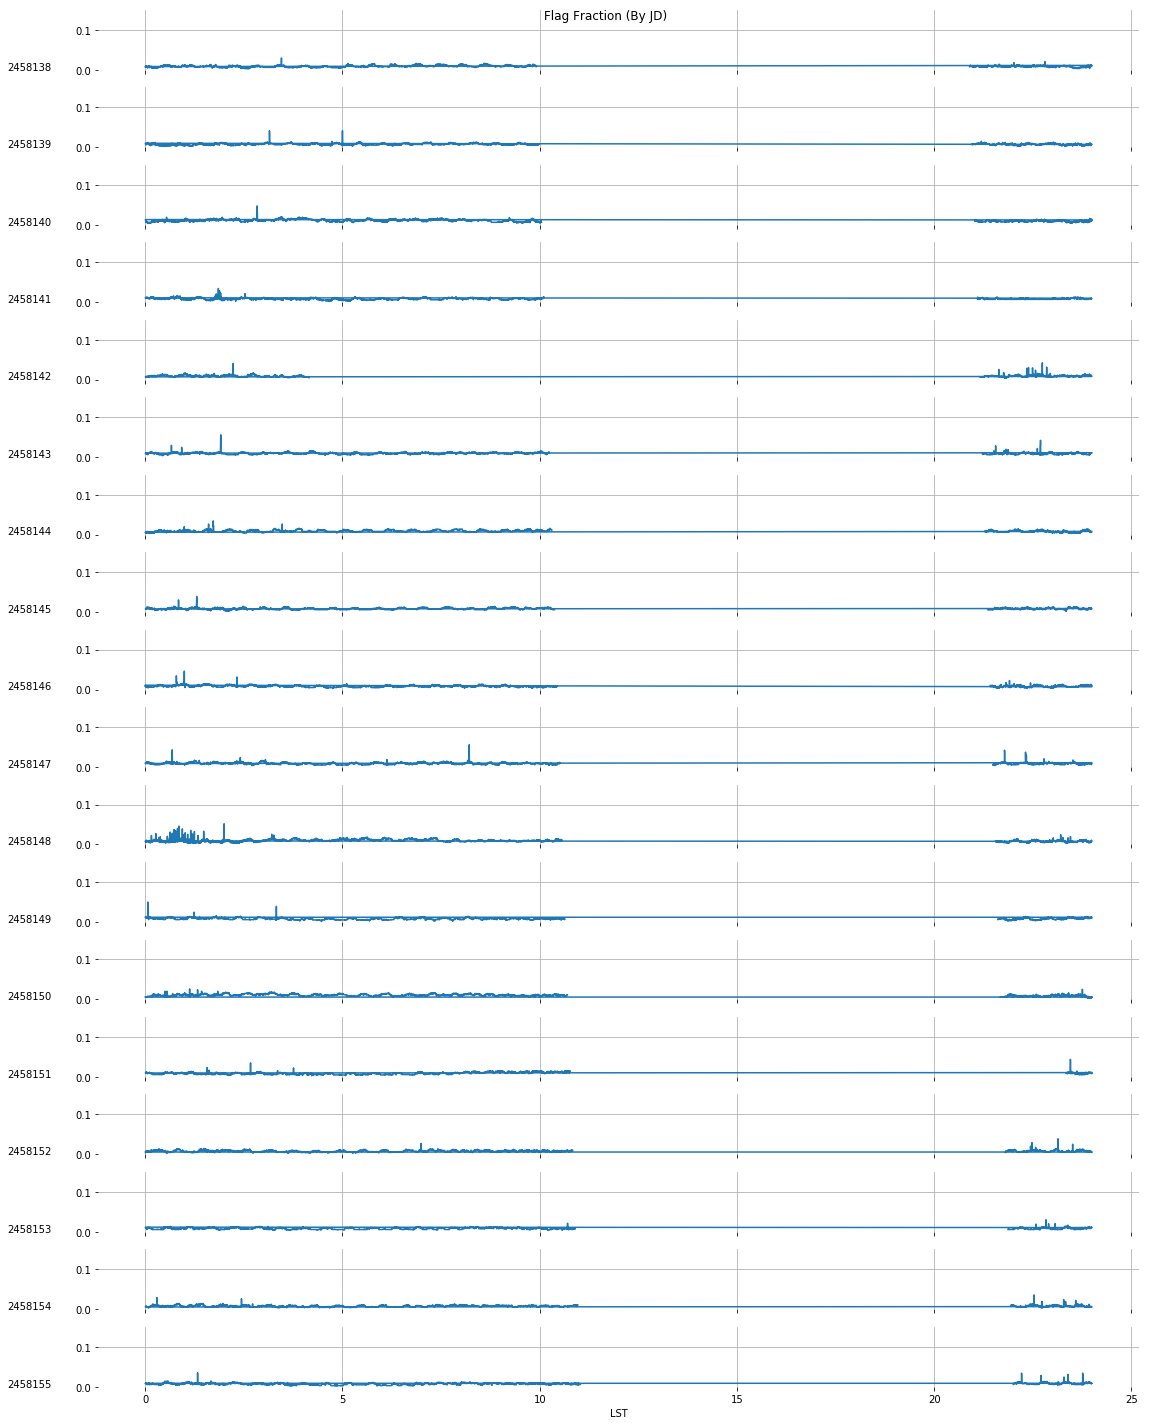

In [20]:
#plot dates featuring BLIP aligned by LST
fig, axarr1=plt.subplots(len(blip_files_1), 1, sharex='col', figsize=(15,20), facecolor='w', constrained_layout=True)
plt.xlabel('LST')
fig.suptitle('Flag Fraction (By JD)')
for i, plotfile in enumerate(blip_files_1):
#     print i
    openFile=np.load(plotfile)
    if int(os.path.split(plotfile)[1][:7])>2458040:
        axarr1[i].plot(blip_time_LST1[i], openFile['chan_mean_xx'], ls='-')
    else:
        axarr1[i].plot(blip_time_LST1[i], openFile['chan_mean_xx_old'], ls='-')

    axarr1[i].yaxis.set_visible(True)
    axarr1[i].set_ylim(0,.15)
    axarr1[i].tick_params(axis='x', bottom=True)
    axarr1[i].set_frame_on(False)
    axarr1[i].text(-3.5,0, blip_notes1[i][0])
    axarr1[i].grid()
    


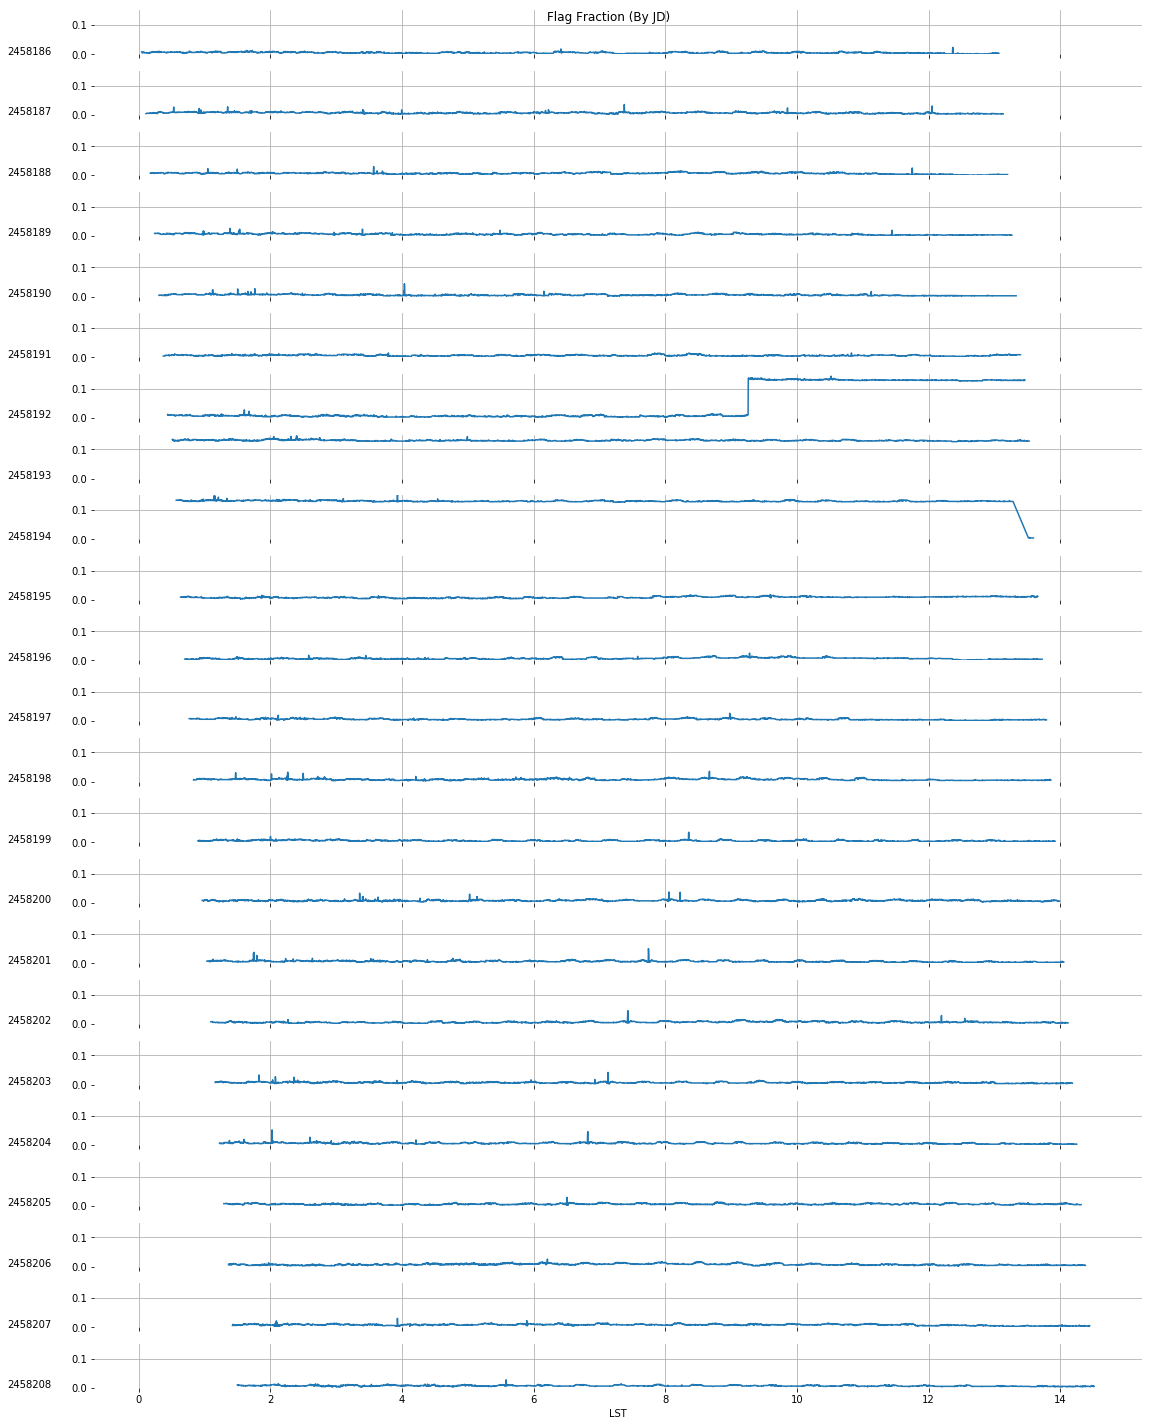

In [21]:
#plot dates featuring BLIP aligned by LST
fig, axarr2=plt.subplots(len(blip_files_2), 1, sharex='col', figsize=(15,20), facecolor='w', constrained_layout=True)
plt.xlabel('LST')
fig.suptitle('Flag Fraction (By JD)')
for i, plotfile in enumerate(blip_files_2):
#     print i
    openFile=np.load(plotfile)
    if int(os.path.split(plotfile)[1][:7])>2458040:
        axarr2[i].plot(blip_time_LST2[i], openFile['chan_mean_xx'], ls='-')
    else:
        axarr2[i].plot(blip_time_LST2[i], openFile['chan_mean_xx_old'], ls='-')

    axarr2[i].yaxis.set_visible(True)
    axarr2[i].set_ylim(0,.15)
    axarr2[i].tick_params(axis='x', bottom=True)
    axarr2[i].set_frame_on(False)
    axarr2[i].text(-2,0, blip_notes2[i][0])
    axarr2[i].grid()
    


Now that we have narrowed down the times the blip can be seen, we can view each one and find the LST for it.

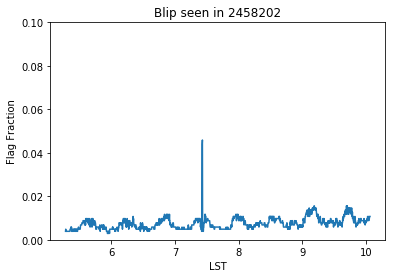

2458202
719
2458202.3886095462
2018-03-24 21:19:35.864795
7h25m53.6276s


In [82]:
blipInd=16 #selects JD
low=1400
high=3000
blipfile=np.load(blip_files_2[blipInd])
blipYDT=blip_time_YDT2[blipInd]
blipLST=blip_time_LST2[blipInd]

plt.figure(2, facecolor='w')
plt.plot(blipLST[low:high], blipfile['chan_mean_xx'][low:high])
plt.title('Blip seen in '+ blip_notes2[blipInd][0])
plt.ylim(0,.1)
plt.xlabel('LST')
plt.ylabel('Flag Fraction')
plt.show()
maxInd=np.argmax(blipfile['chan_mean_xx'][low:high])
print(blip_notes2[blipInd][0])
print(maxInd)
print(blipfile['flag_times_xx'][low:high][maxInd])
print(blipYDT[low:high][maxInd])
print(blipLST[low:high][maxInd])


In [43]:
uv_path='/data4/dmlewis/data/blip/2458202/'
uv_file=glob.glob(uv_path+ 'zen.2458202.38625.xx.HH.uv')
uv_file.sort()
print(uv_file)

['/data4/dmlewis/data/blip/2458202/zen.2458202.38625.xx.HH.uv']


In [44]:
uv=UVData()
uv.read_miriad(uv_file[0])

In [45]:
uv_waterfall_xx=[]
uv_times_xx=[]
ant1=1
ant2=11
timelen=uv.Ntimes
numbaseline=uv.Nbls
uv_times_xx.extend(uv.get_times(ant1, ant2))
waterfalltempxx=np.reshape(uv.data_array, (timelen, numbaseline, 1,1024,1)) #reshape so I can average over baselines
print (waterfalltempxx.shape)
uv_waterfall_xx.extend(np.average(waterfalltempxx, axis=1).squeeze())

(60, 2278, 1, 1024, 1)


In [46]:
freqTicks=np.linspace(100,200, 1024)
freqLabel=[0]*len(freqTicks)
float_formatter = lambda x: "%.2f" % x
for i, num in enumerate (freqTicks):
    freqLabel[i]='{:.6}'.format(num)
#print (freqLabel)

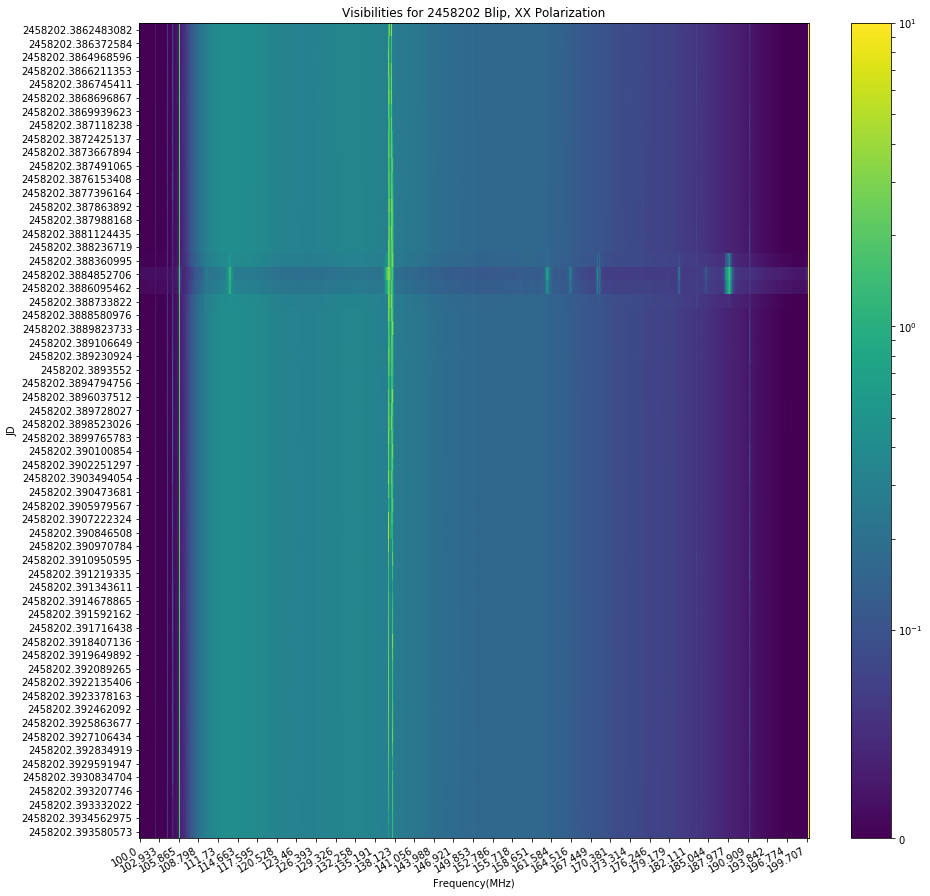

In [47]:
plt.figure(figsize=(15,15))
plt.imshow(np.abs(uv_waterfall_xx[:]),aspect='auto',norm=SymLogNorm(vmin=0,vmax=10,linthresh=.1) )
plt.yticks(np.arange(0,len(uv_waterfall_xx)),uv_times_xx[::])
plt.xticks(np.arange(0,1024,30),freqLabel[::30], rotation=30, ha='right')
plt.ylabel('JD')
plt.xlabel('Frequency(MHz)')
plt.title('Visibilities for 2458202 Blip, XX Polarization')
plt.colorbar()
plt.show()

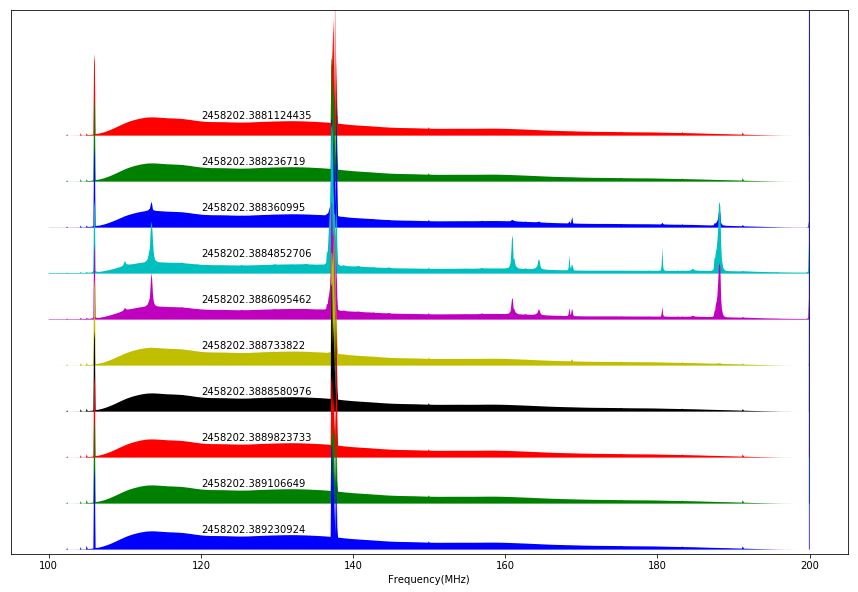

In [80]:
#set displacement for joy plot
displace = (1.1)
chans=np.linspace(0,1024,1024)
freqs=np.linspace(100, 200, num=len(uv_waterfall_xx[19]))
# Add a cutoff
# chantrail[chantrail<=0] = None

face_colors = itertools.cycle(['r','g','b','c','m','y','k']) #rotate through these colors

#Create a joyplot of the graphs above for time average
fig = plt.figure(figsize=(15,10))
gs1=GridSpec(nrows=1,ncols=1,width_ratios=[1]) #gridspec is used to keep subplots neat
gs1.update(wspace=1, hspace=0, )
ax = fig.add_subplot(gs1[:,:1])
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(False)
ax.set_ylim(-10,3)
ax.set_xlabel('Frequency(MHz)')
for n,y in enumerate(uv_waterfall_xx[15:25]):
    # Vertically displace each plot. This makes labeling funky, so the daily average will be labeled instead.
    y0 = np.ones(y.shape) * -n * displace
    y1 = np.abs(y) - n*displace

    #plt.plot(chans,y1,lw=1, color=face_colors.next(),zorder=-len(chantrail)+n)
    plt.fill_between(freqs, y0,y1,lw=0, edgecolor='black',facecolor=face_colors.next(),zorder=-len(uv_waterfall_xx)+n)
    plt.text(120,y0[0]+.4,uv_times_xx[15:25][n], color='black')
plt.show()

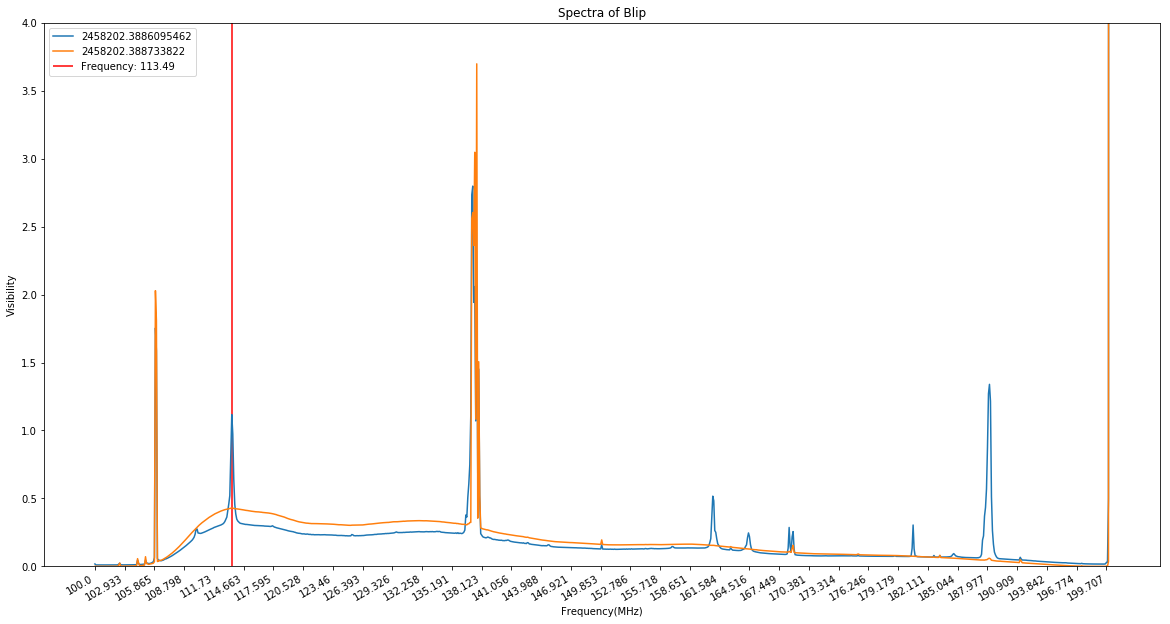

113.49


In [59]:
plt.figure(figsize=(20,10))
pInd=138
plow=0
phigh=1024
plt.plot(uv_waterfall_xx[19][plow:phigh], label=uv_times_xx[19])
#plt.plot(freqLabel[plow:phigh],uv_waterfall_xx[19][plow:phigh])
plt.plot(uv_waterfall_xx[20][plow:phigh], label=uv_times_xx[20])
plt.title('Spectra of Blip')
plt.vlines(pInd,0,4, color='r', label='Frequency: '+ freqLabel[plow:phigh][pInd])
plt.ylabel('Visibility')
plt.xlabel('Frequency(MHz)')
plt.ylim(0,4)
plt.legend()
plt.xticks(np.arange(0,1024,30),freqLabel[::30], rotation=30, ha='right')
plt.show()
print(freqLabel[plow:phigh][pInd])